In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [60]:
# Load dataset

df = pd.read_csv("dataset.csv")

# Drop unnamed columns
df.drop(
    df.columns[df.columns.str.contains("unnamed", case=False)], axis=1, inplace=True
)  # drop unnamed column
df.dropna(inplace=True)  # drop rows with null values

# Convert 'explicit' boolean to integer (0/1)
df["explicit"] = df["explicit"].astype(int)

# One-hot encode categorical features
df = pd.get_dummies(
    df, columns=["key", "time_signature", "track_genre"], drop_first=True
)

# Make valence binary for classification
df["valence"] = df["valence"].astype("category")
df["valence"] = df["valence"].map(
    lambda x: 0 if x < 0.5 else 1
)  # sets valence to 0 if sad, 1 if happy

# Drop unneeded features and make valence our target feature
X = df.drop(["track_id", "artists", "album_name", "track_name", "valence", "duration_ms"], axis=1)
y = df["valence"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

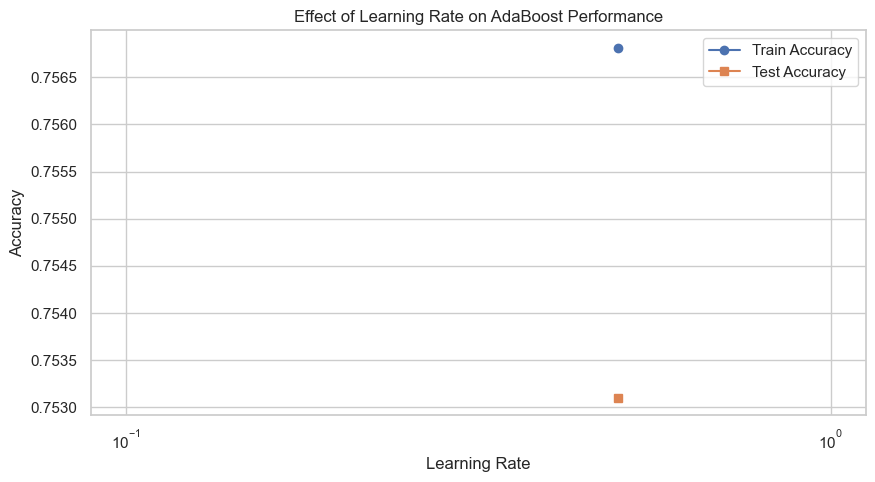

In [ ]:
# Base estimator (Decision Tree with max depth to prevent overfitting)
base_tree = DecisionTreeClassifier(criterion="entropy", max_depth=5)
lr = 0.5

# Boosted model (C5.0-like)
model = AdaBoostClassifier(estimator=base_tree, n_estimators=50, learning_rate=lr)
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)

In [62]:
# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)

Accuracy: 0.7531

Confusion Matrix:
 [[14275  4296]
 [ 4148 11481]]

Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.77      0.77     18571
           1       0.73      0.73      0.73     15629

    accuracy                           0.75     34200
   macro avg       0.75      0.75      0.75     34200
weighted avg       0.75      0.75      0.75     34200



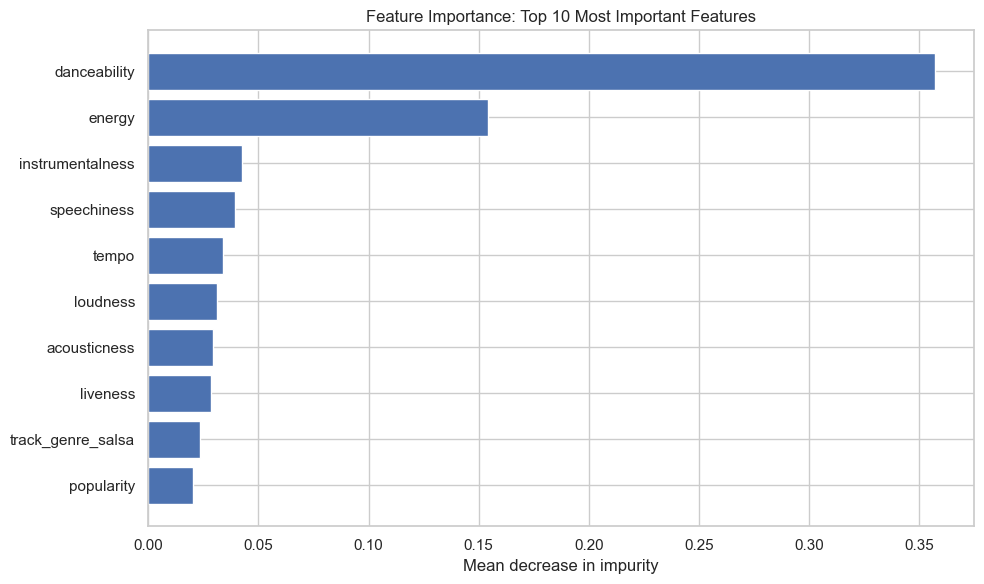

In [63]:
# Number of top features to display
top_n = 10

# Get feature importances and sort them
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]  # Descending order

# Select top N
top_indices = indices[:top_n]
top_features = X.columns[top_indices]
top_importances = importances[top_indices]


# Plot
plt.figure(figsize=(10, 6))
plt.barh(
    range(top_n), top_importances[::-1], align="center"
)  # Reverse for best-first top-down
plt.yticks(range(top_n), top_features[::-1])
plt.xlabel("Mean decrease in impurity")
plt.title(f"Feature Importance: Top {top_n} Most Important Features")
plt.tight_layout()
plt.show()

[Text(0.5, 0.9166666666666666, 'danceability <= 0.518\nentropy = 0.995\nsamples = 100.0%\nvalue = [0.542, 0.458]\nclass = Sad'),
 Text(0.25, 0.75, 'danceability <= 0.332\nentropy = 0.786\nsamples = 36.3%\nvalue = [0.766, 0.234]\nclass = Sad'),
 Text(0.375, 0.8333333333333333, 'True  '),
 Text(0.125, 0.5833333333333334, 'energy <= 0.426\nentropy = 0.416\nsamples = 10.2%\nvalue = [0.916, 0.084]\nclass = Sad'),
 Text(0.0625, 0.4166666666666667, 'danceability <= 0.267\nentropy = 0.148\nsamples = 4.5%\nvalue = [0.979, 0.021]\nclass = Sad'),
 Text(0.03125, 0.25, 'tempo <= 152.101\nentropy = 0.059\nsamples = 2.9%\nvalue = [0.993, 0.007]\nclass = Sad'),
 Text(0.015625, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.046875, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.09375, 0.25, 'track_genre_classical <= 0.5\nentropy = 0.277\nsamples = 1.6%\nvalue = [0.952, 0.048]\nclass = Sad'),
 Text(0.078125, 0.08333333333333333, '\n  (...)  \n'),
 Text(0.109375, 0.08333333333333333, '\n  (...)  \n'),
 T

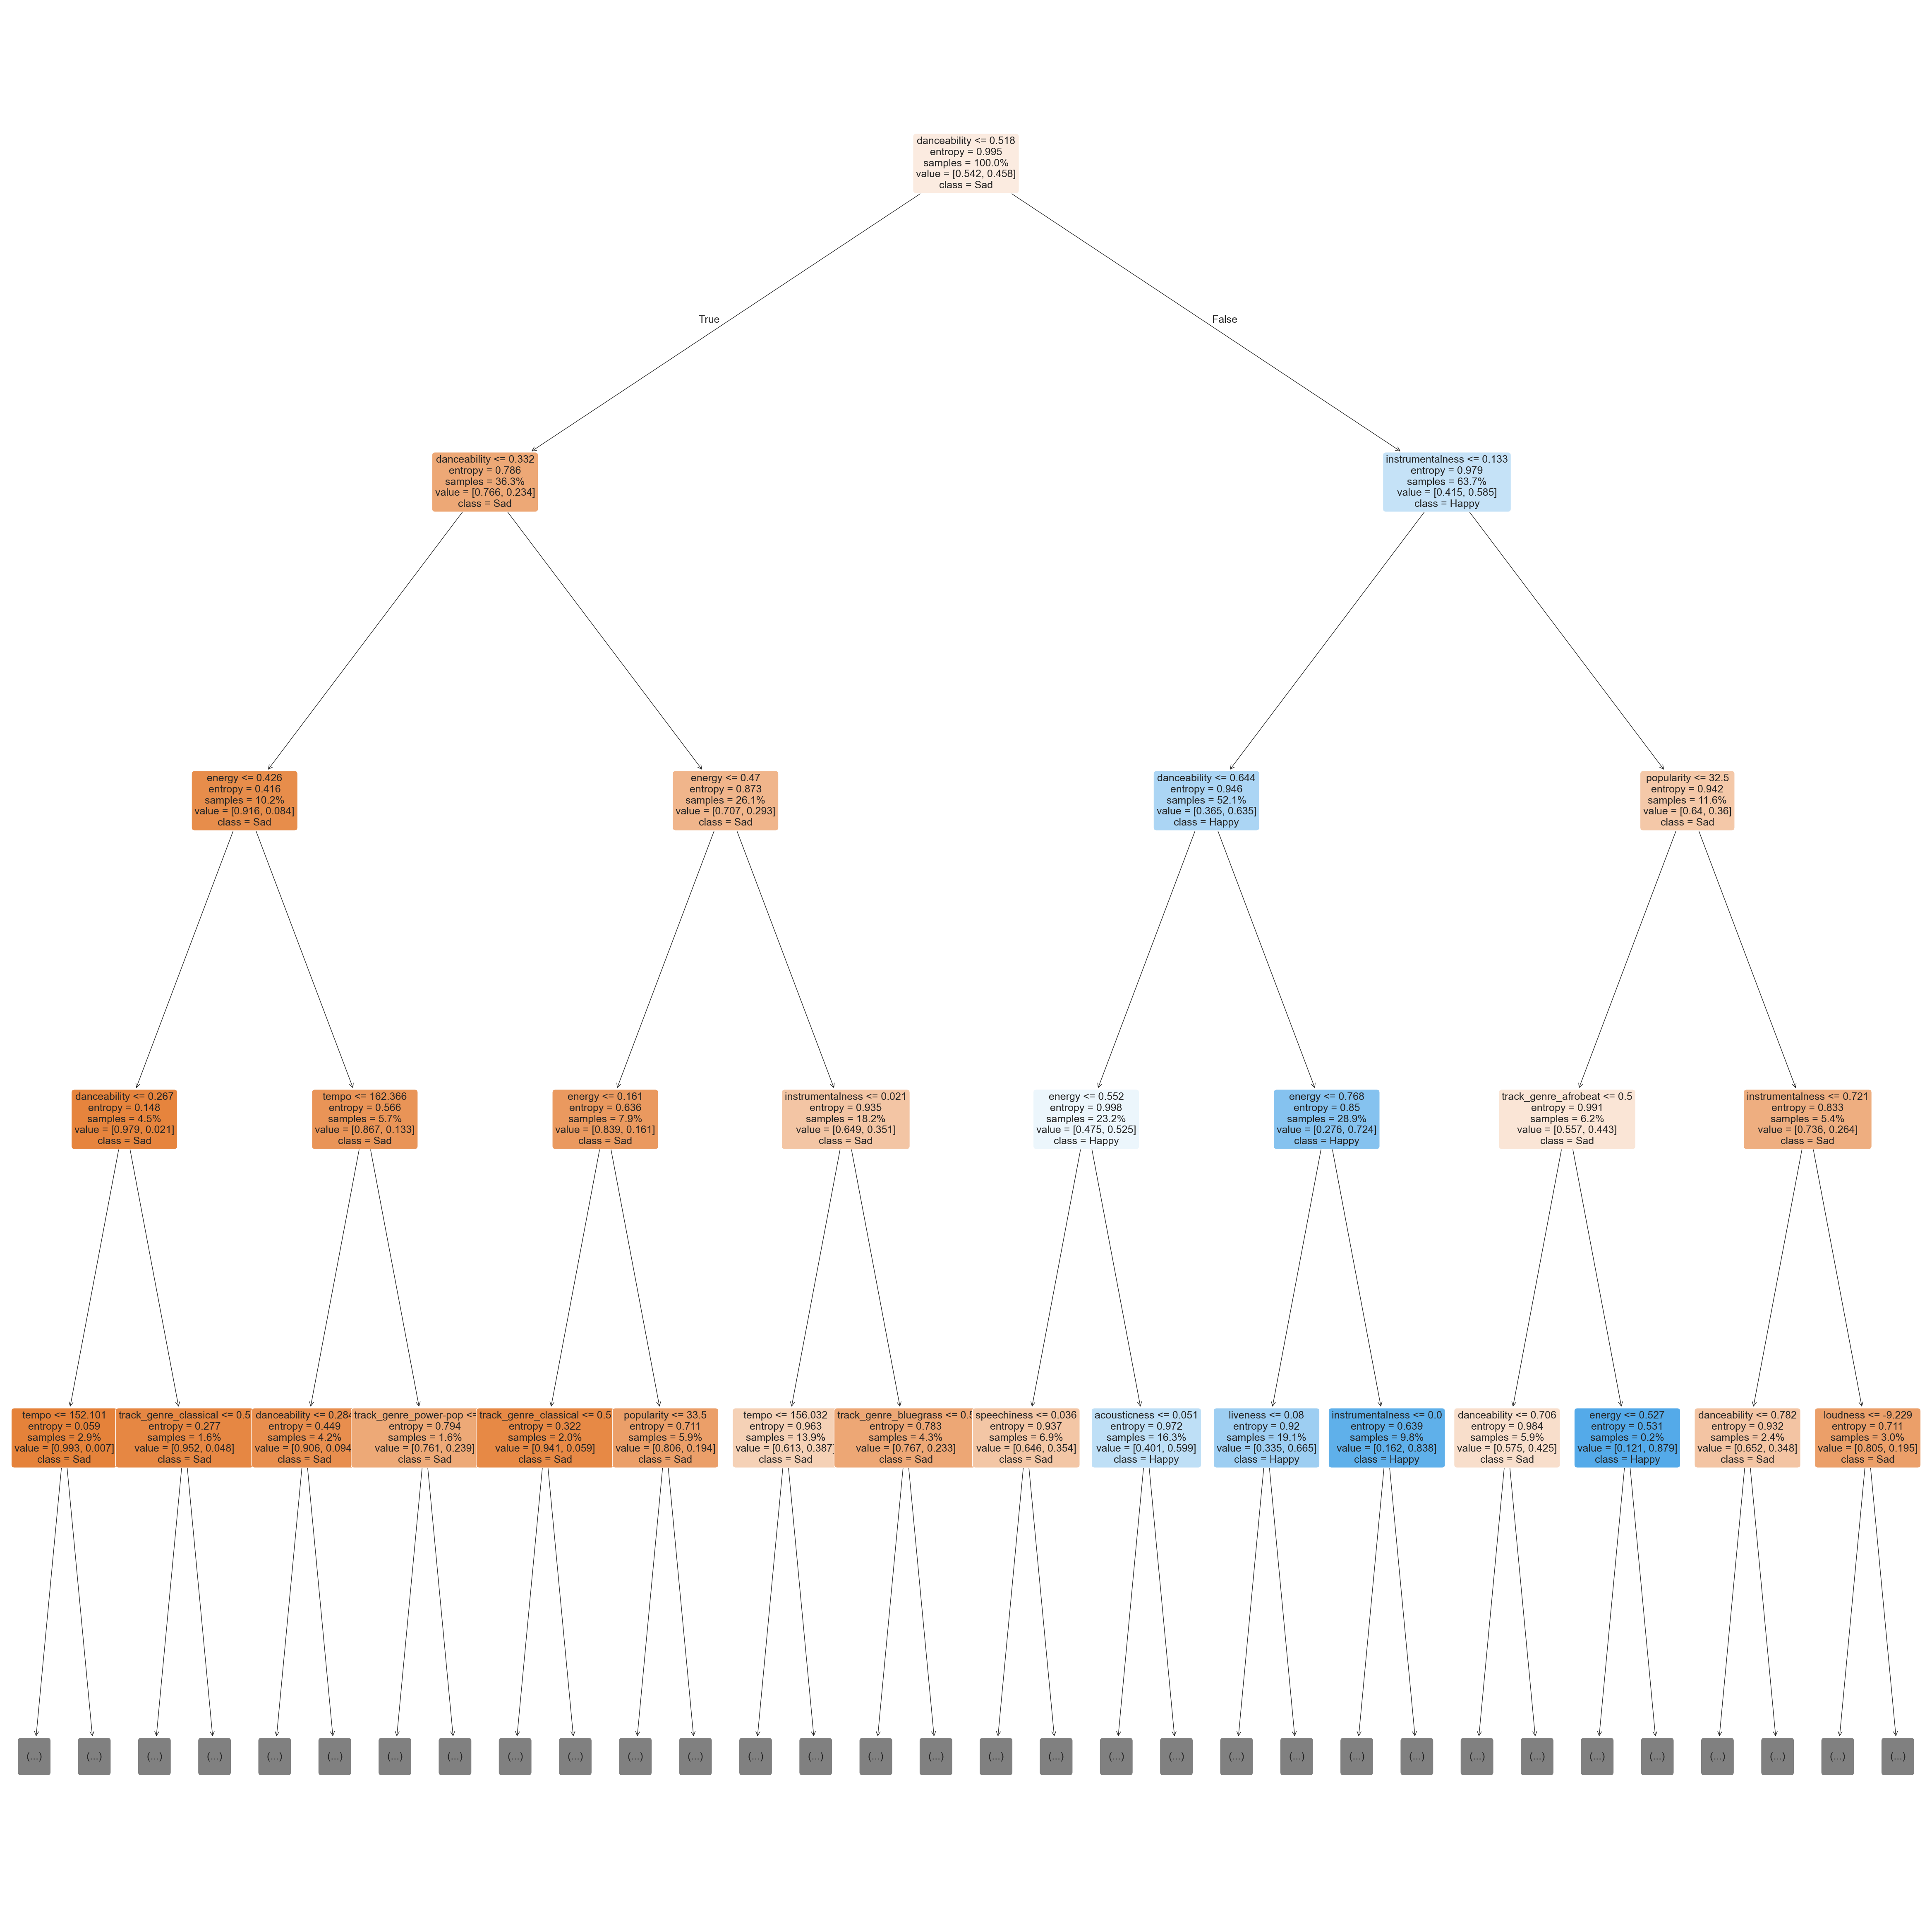

In [64]:
single_tree = model.estimators_[0]
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(60, 60))
plot_tree(
    single_tree,
    max_depth=4,
    fontsize=18,
    filled=True,
    feature_names=X.columns,
    class_names=["Sad", "Happy"],
    rounded=True,
    proportion=True
)

In [67]:
test_actual = X_test  # Copy attr_test
test_actual["target_pred"] = y_pred  # Create new column for prediction values
test_actual["test_actual"] = y_test  # Create new column for actual values
# test_actual.head()  # Show table

false_positives = test_actual[
    (test_actual["target_pred"] == 1) & (test_actual["test_actual"] == 0)
]

false_negatives = test_actual[
    (test_actual["target_pred"] == 0) & (test_actual["test_actual"] == 1)
]

true_positives = test_actual[
    (test_actual["target_pred"] == 1) & (test_actual["test_actual"] == 1)
]

true_negatives = test_actual[
    (test_actual["target_pred"] == 0) & (test_actual["test_actual"] == 0)
]


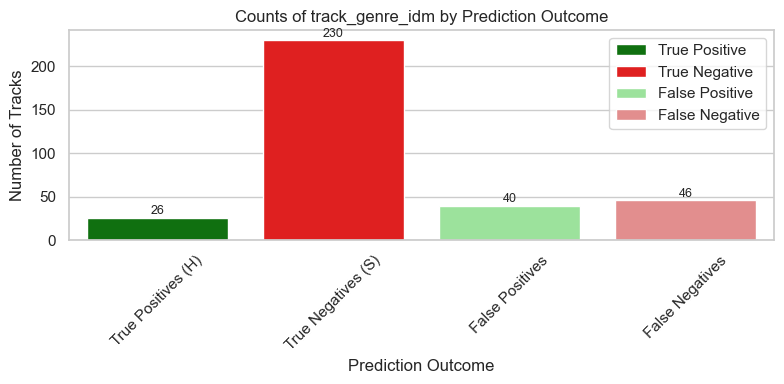

True Positives (H)     26
True Negatives (S)    230
False Positives        40
False Negatives        46
Name: track_genre_idm, dtype: int64


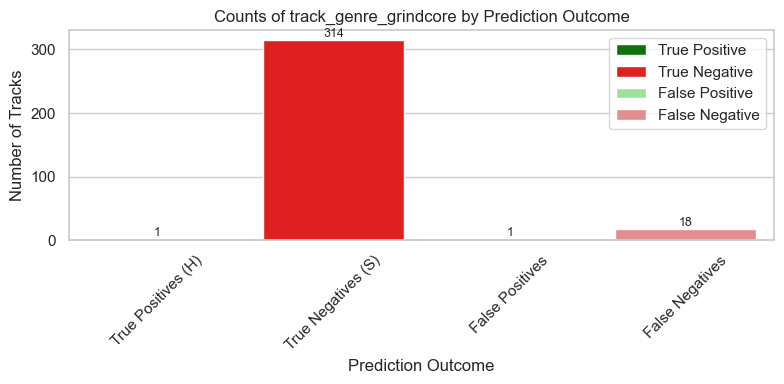

True Positives (H)      1
True Negatives (S)    314
False Positives         1
False Negatives        18
Name: track_genre_grindcore, dtype: int64


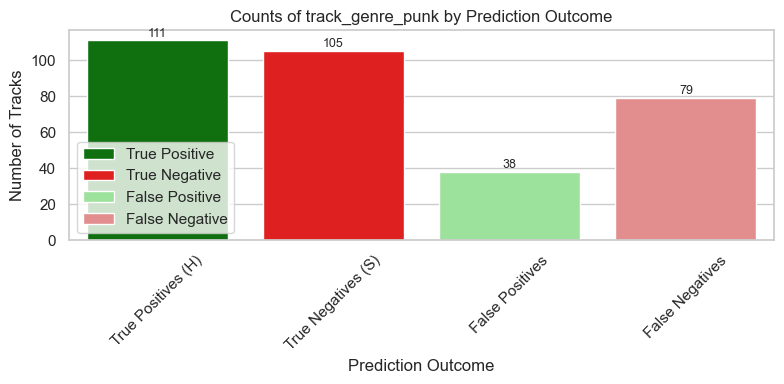

True Positives (H)    111
True Negatives (S)    105
False Positives        38
False Negatives        79
Name: track_genre_punk, dtype: int64


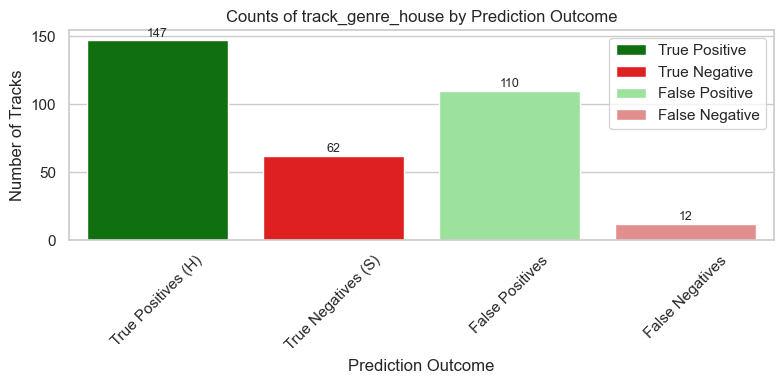

True Positives (H)    147
True Negatives (S)     62
False Positives       110
False Negatives        12
Name: track_genre_house, dtype: int64


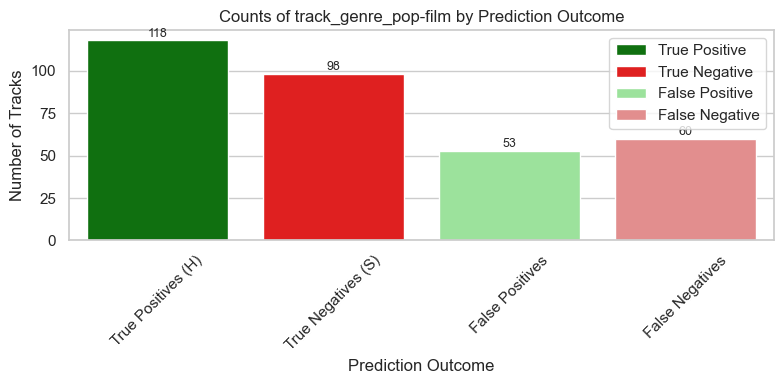

True Positives (H)    118
True Negatives (S)     98
False Positives        53
False Negatives        60
Name: track_genre_pop-film, dtype: int64


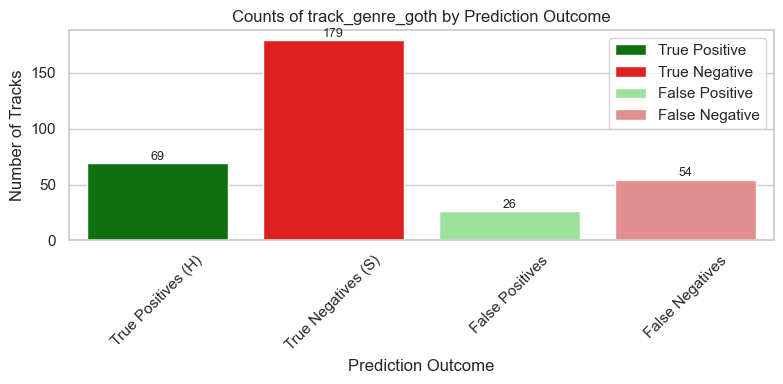

True Positives (H)     69
True Negatives (S)    179
False Positives        26
False Negatives        54
Name: track_genre_goth, dtype: int64


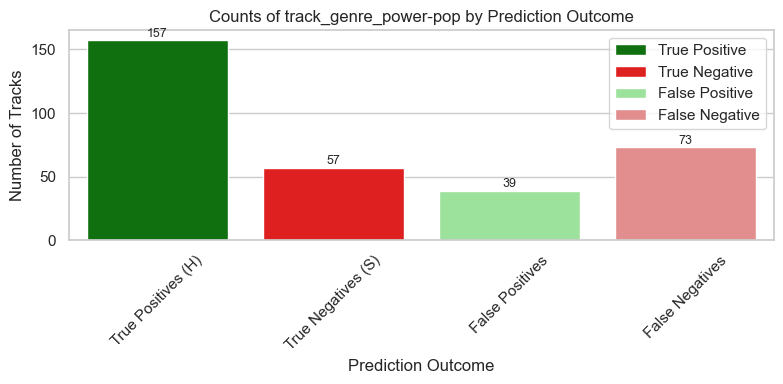

True Positives (H)    157
True Negatives (S)     57
False Positives        39
False Negatives        73
Name: track_genre_power-pop, dtype: int64


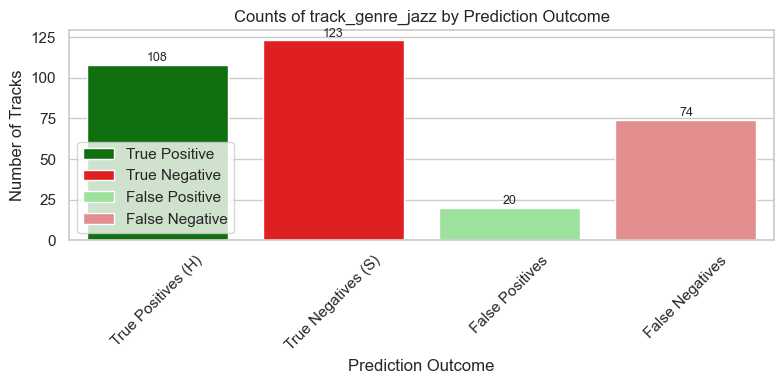

True Positives (H)    108
True Negatives (S)    123
False Positives        20
False Negatives        74
Name: track_genre_jazz, dtype: int64


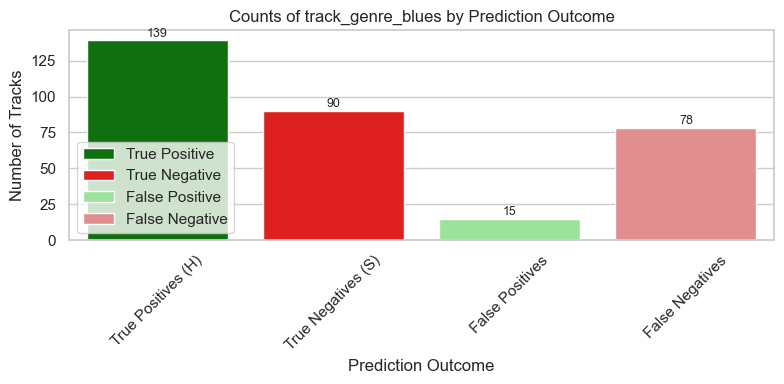

True Positives (H)    139
True Negatives (S)     90
False Positives        15
False Negatives        78
Name: track_genre_blues, dtype: int64


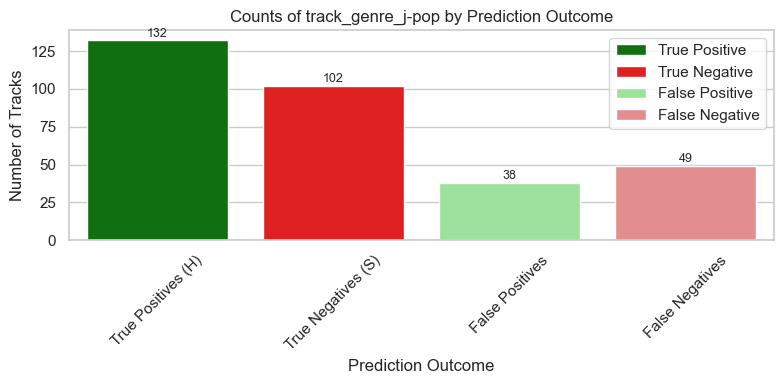

True Positives (H)    132
True Negatives (S)    102
False Positives        38
False Negatives        49
Name: track_genre_j-pop, dtype: int64


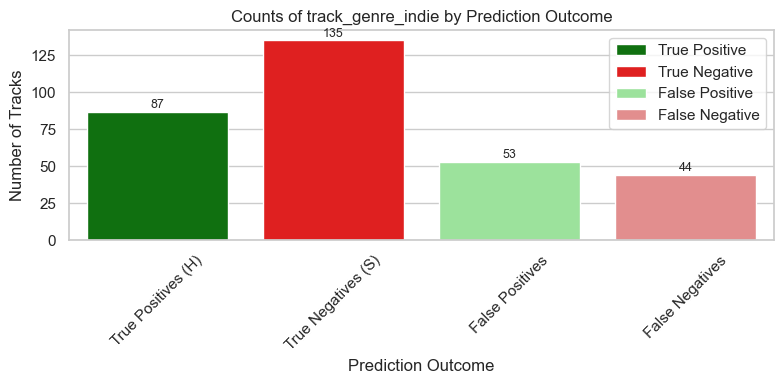

True Positives (H)     87
True Negatives (S)    135
False Positives        53
False Negatives        44
Name: track_genre_indie, dtype: int64


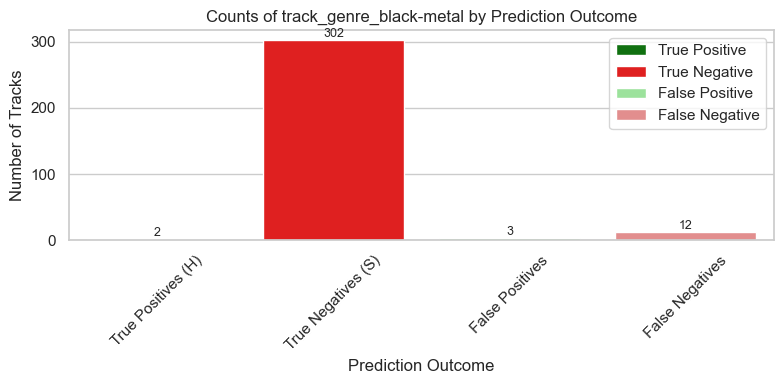

True Positives (H)      2
True Negatives (S)    302
False Positives         3
False Negatives        12
Name: track_genre_black-metal, dtype: int64


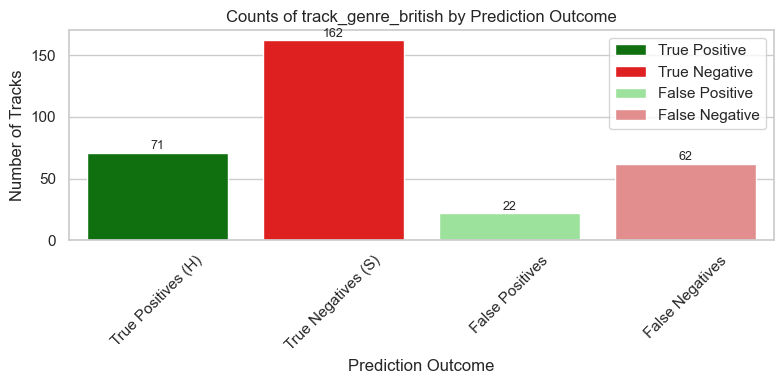

True Positives (H)     71
True Negatives (S)    162
False Positives        22
False Negatives        62
Name: track_genre_british, dtype: int64


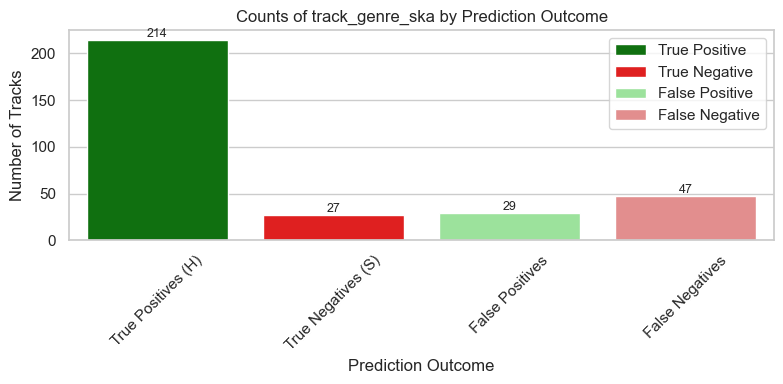

True Positives (H)    214
True Negatives (S)     27
False Positives        29
False Negatives        47
Name: track_genre_ska, dtype: int64


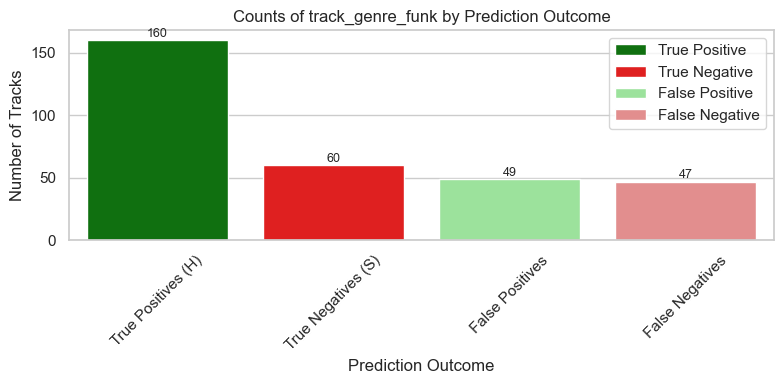

True Positives (H)    160
True Negatives (S)     60
False Positives        49
False Negatives        47
Name: track_genre_funk, dtype: int64


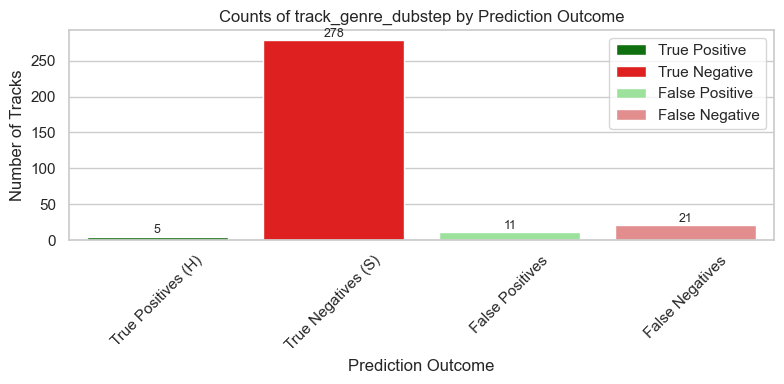

True Positives (H)      5
True Negatives (S)    278
False Positives        11
False Negatives        21
Name: track_genre_dubstep, dtype: int64


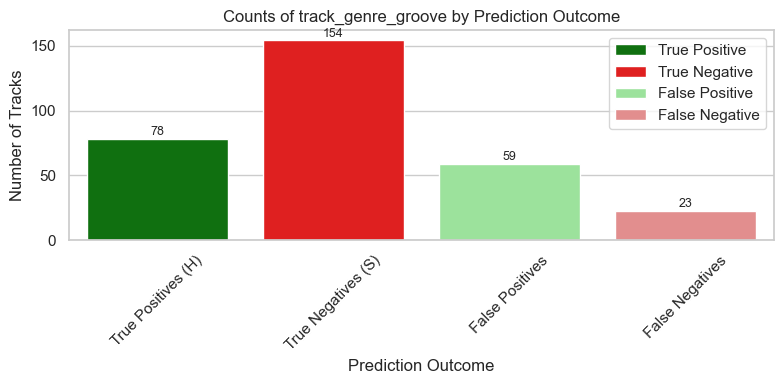

True Positives (H)     78
True Negatives (S)    154
False Positives        59
False Negatives        23
Name: track_genre_groove, dtype: int64


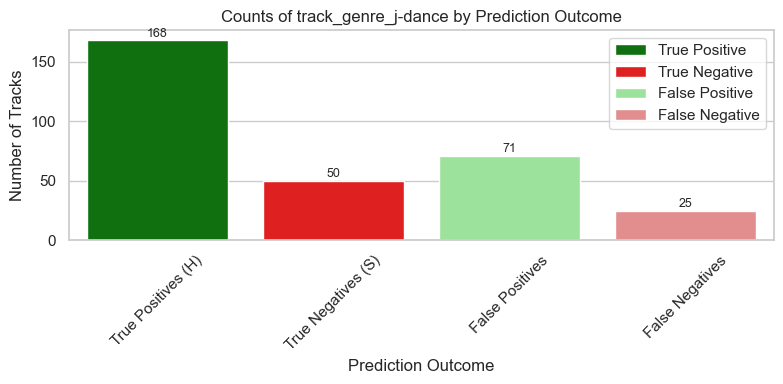

True Positives (H)    168
True Negatives (S)     50
False Positives        71
False Negatives        25
Name: track_genre_j-dance, dtype: int64


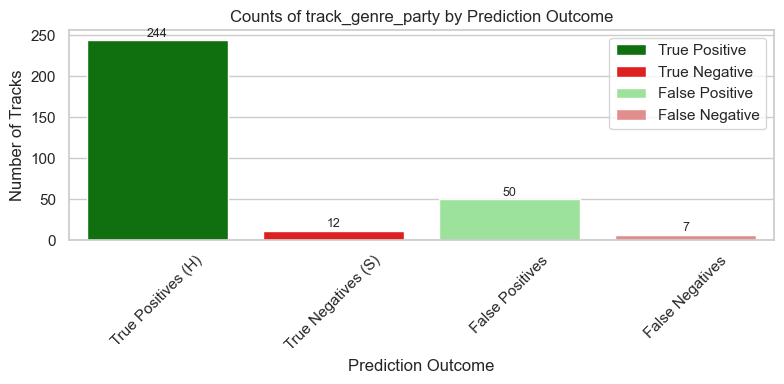

True Positives (H)    244
True Negatives (S)     12
False Positives        50
False Negatives         7
Name: track_genre_party, dtype: int64


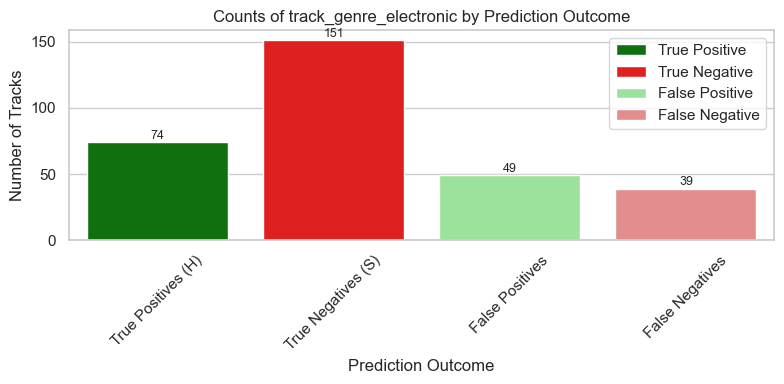

True Positives (H)     74
True Negatives (S)    151
False Positives        49
False Negatives        39
Name: track_genre_electronic, dtype: int64


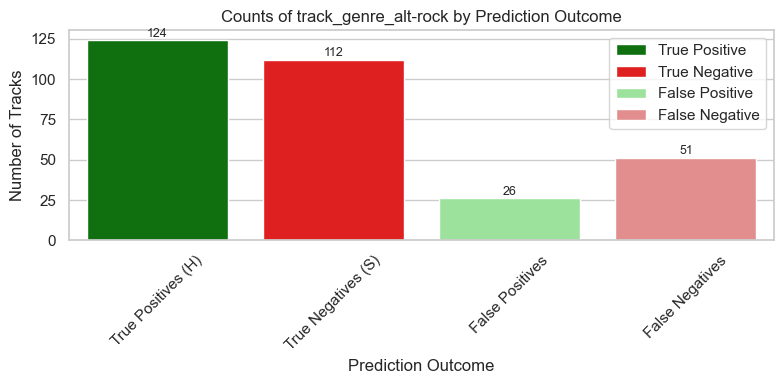

True Positives (H)    124
True Negatives (S)    112
False Positives        26
False Negatives        51
Name: track_genre_alt-rock, dtype: int64


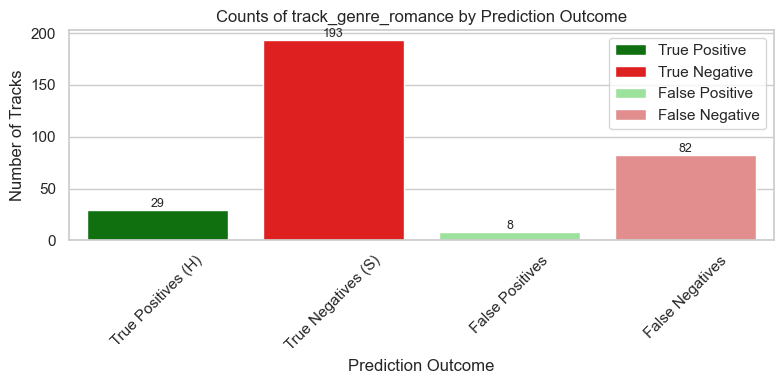

True Positives (H)     29
True Negatives (S)    193
False Positives         8
False Negatives        82
Name: track_genre_romance, dtype: int64


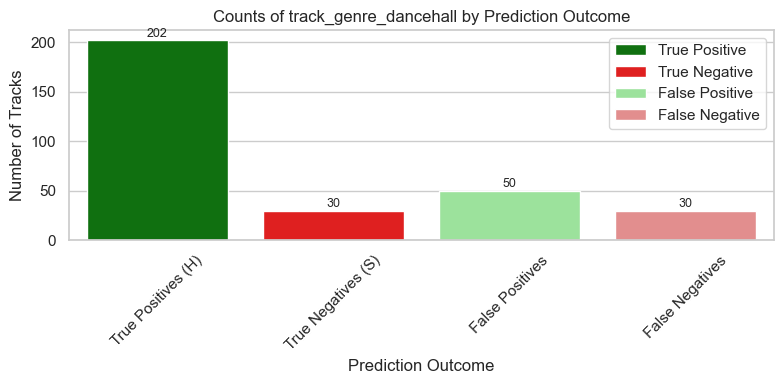

True Positives (H)    202
True Negatives (S)     30
False Positives        50
False Negatives        30
Name: track_genre_dancehall, dtype: int64


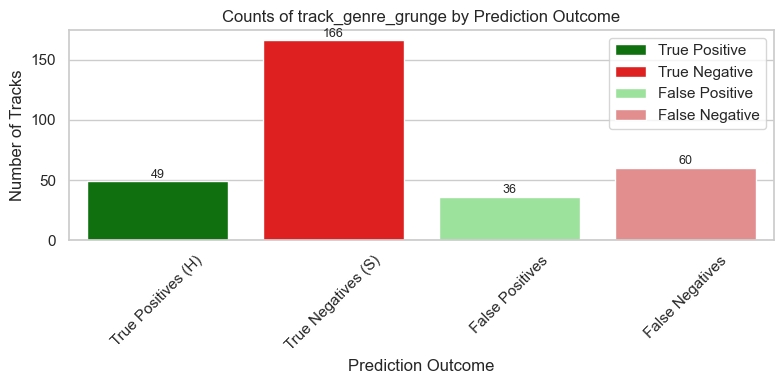

True Positives (H)     49
True Negatives (S)    166
False Positives        36
False Negatives        60
Name: track_genre_grunge, dtype: int64


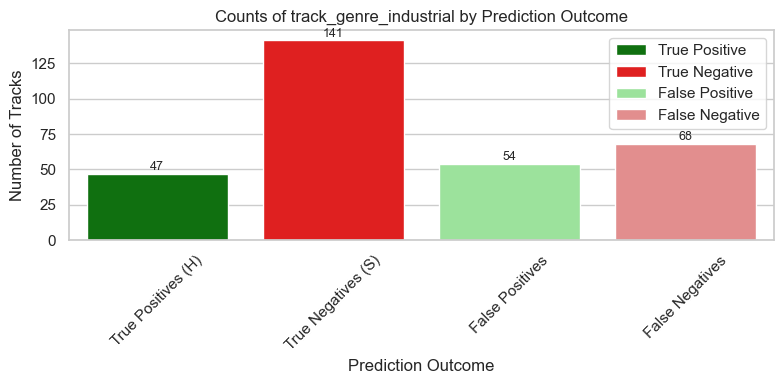

True Positives (H)     47
True Negatives (S)    141
False Positives        54
False Negatives        68
Name: track_genre_industrial, dtype: int64


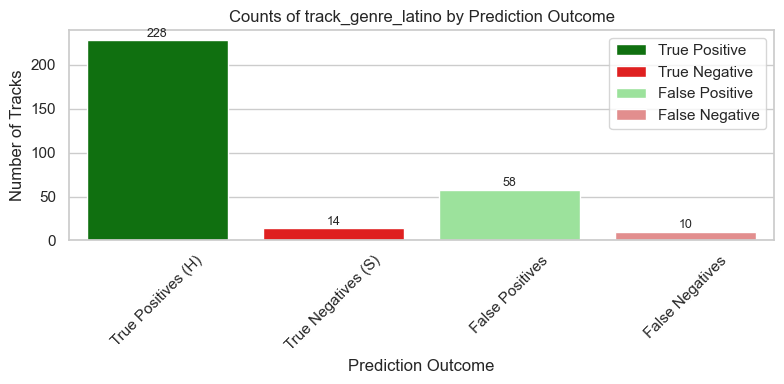

True Positives (H)    228
True Negatives (S)     14
False Positives        58
False Negatives        10
Name: track_genre_latino, dtype: int64


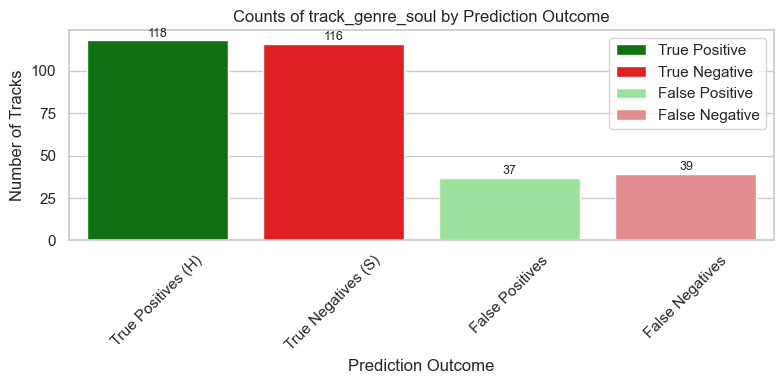

True Positives (H)    118
True Negatives (S)    116
False Positives        37
False Negatives        39
Name: track_genre_soul, dtype: int64


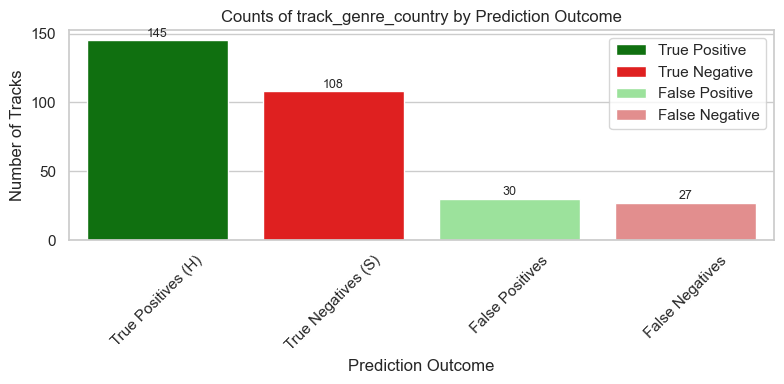

True Positives (H)    145
True Negatives (S)    108
False Positives        30
False Negatives        27
Name: track_genre_country, dtype: int64


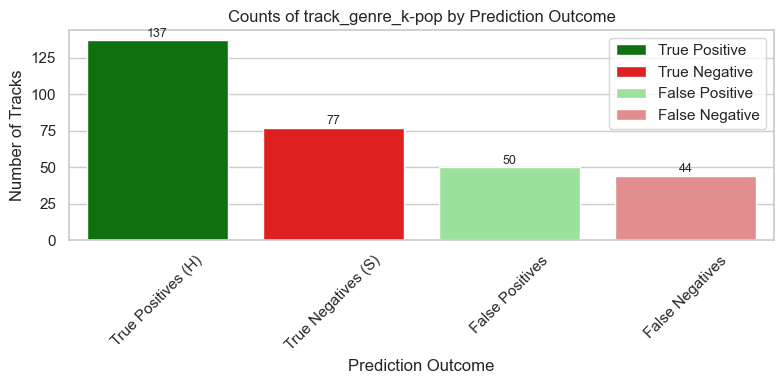

True Positives (H)    137
True Negatives (S)     77
False Positives        50
False Negatives        44
Name: track_genre_k-pop, dtype: int64


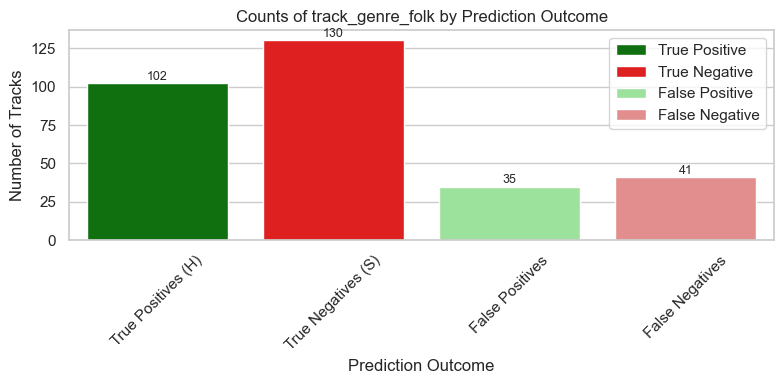

True Positives (H)    102
True Negatives (S)    130
False Positives        35
False Negatives        41
Name: track_genre_folk, dtype: int64


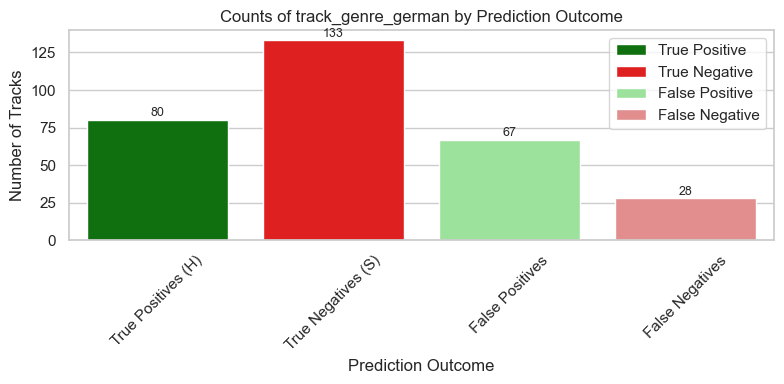

True Positives (H)     80
True Negatives (S)    133
False Positives        67
False Negatives        28
Name: track_genre_german, dtype: int64


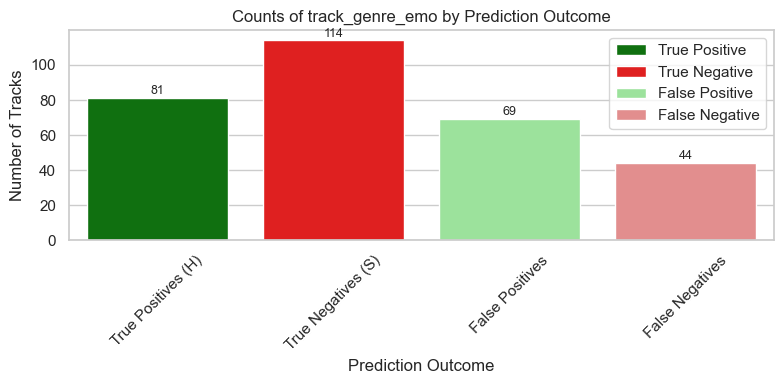

True Positives (H)     81
True Negatives (S)    114
False Positives        69
False Negatives        44
Name: track_genre_emo, dtype: int64


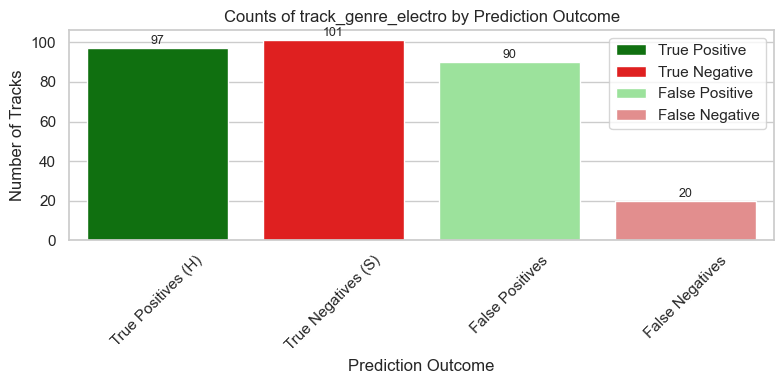

True Positives (H)     97
True Negatives (S)    101
False Positives        90
False Negatives        20
Name: track_genre_electro, dtype: int64


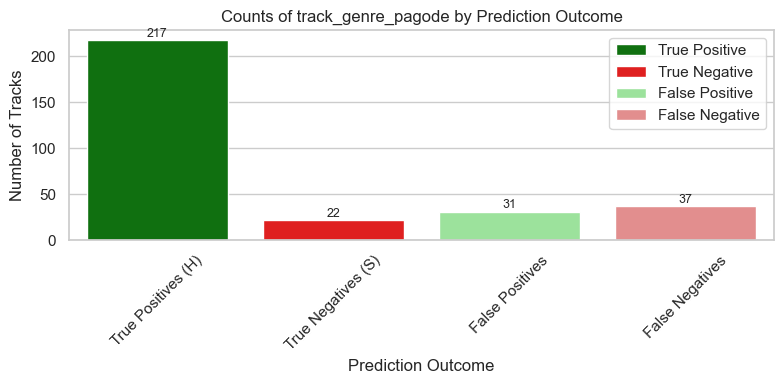

True Positives (H)    217
True Negatives (S)     22
False Positives        31
False Negatives        37
Name: track_genre_pagode, dtype: int64


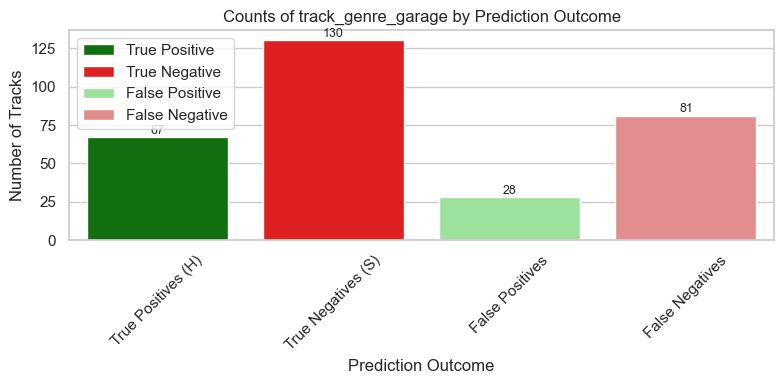

True Positives (H)     67
True Negatives (S)    130
False Positives        28
False Negatives        81
Name: track_genre_garage, dtype: int64


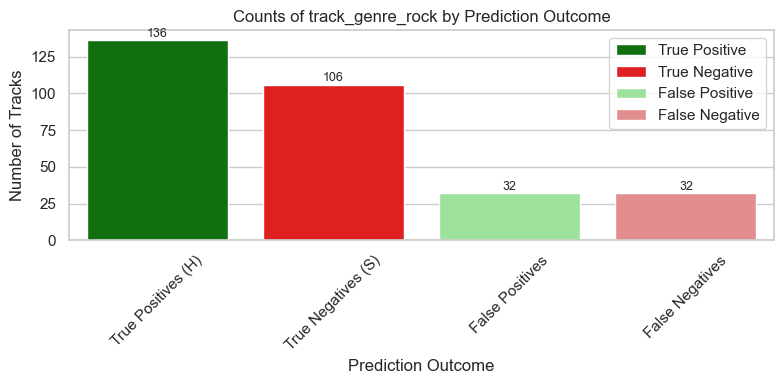

True Positives (H)    136
True Negatives (S)    106
False Positives        32
False Negatives        32
Name: track_genre_rock, dtype: int64


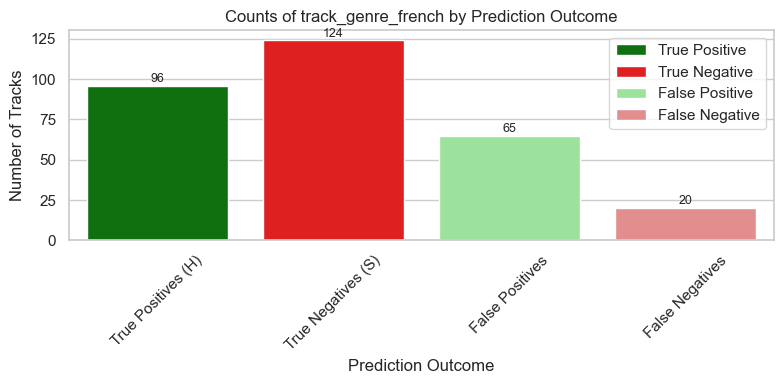

True Positives (H)     96
True Negatives (S)    124
False Positives        65
False Negatives        20
Name: track_genre_french, dtype: int64


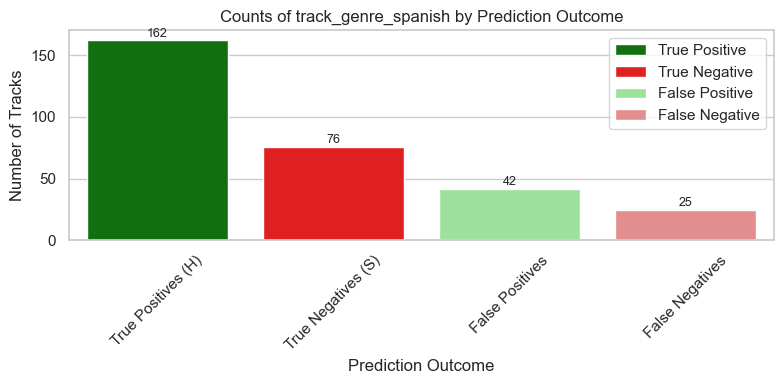

True Positives (H)    162
True Negatives (S)     76
False Positives        42
False Negatives        25
Name: track_genre_spanish, dtype: int64


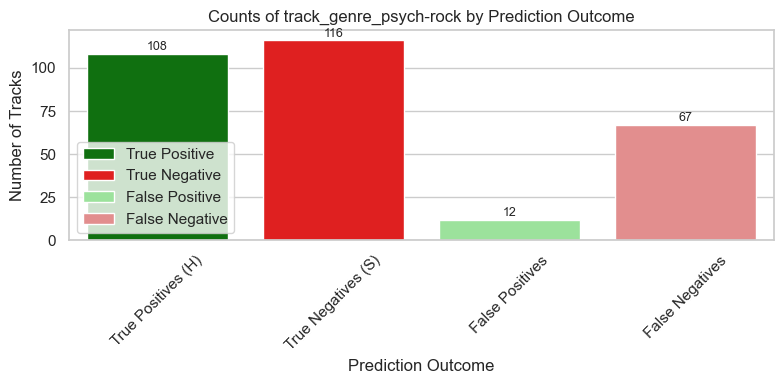

True Positives (H)    108
True Negatives (S)    116
False Positives        12
False Negatives        67
Name: track_genre_psych-rock, dtype: int64


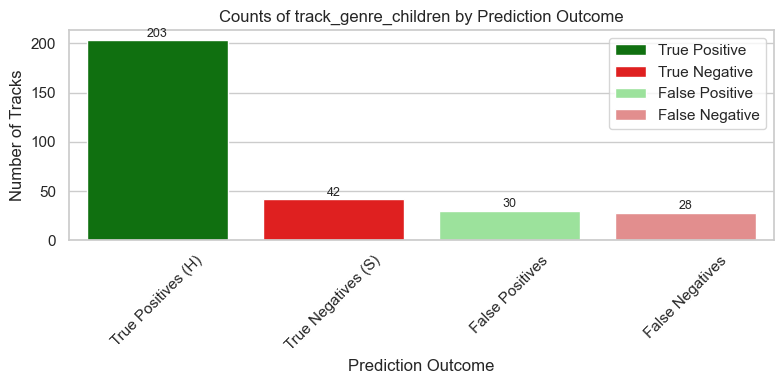

True Positives (H)    203
True Negatives (S)     42
False Positives        30
False Negatives        28
Name: track_genre_children, dtype: int64


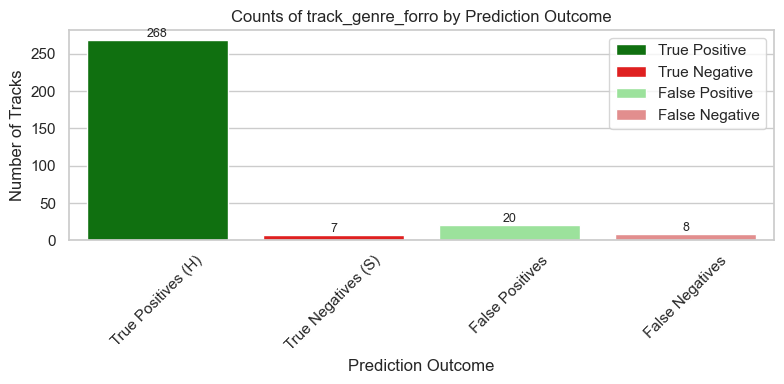

True Positives (H)    268
True Negatives (S)      7
False Positives        20
False Negatives         8
Name: track_genre_forro, dtype: int64


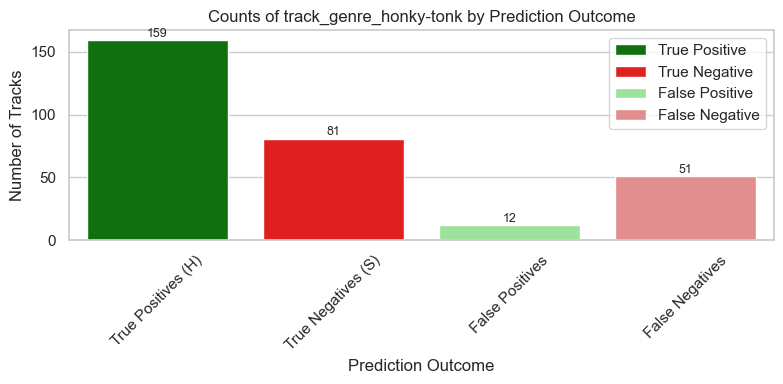

True Positives (H)    159
True Negatives (S)     81
False Positives        12
False Negatives        51
Name: track_genre_honky-tonk, dtype: int64


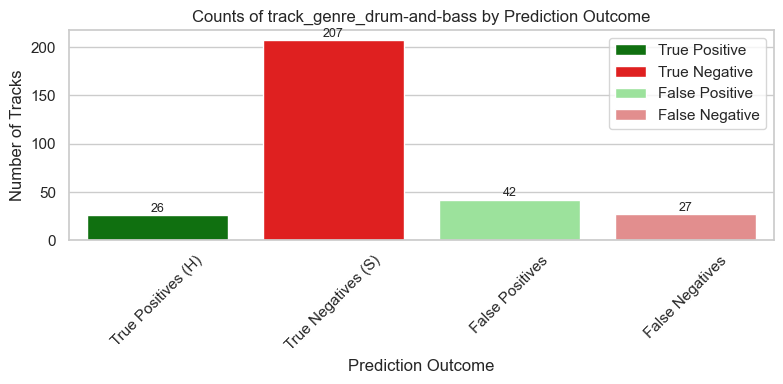

True Positives (H)     26
True Negatives (S)    207
False Positives        42
False Negatives        27
Name: track_genre_drum-and-bass, dtype: int64


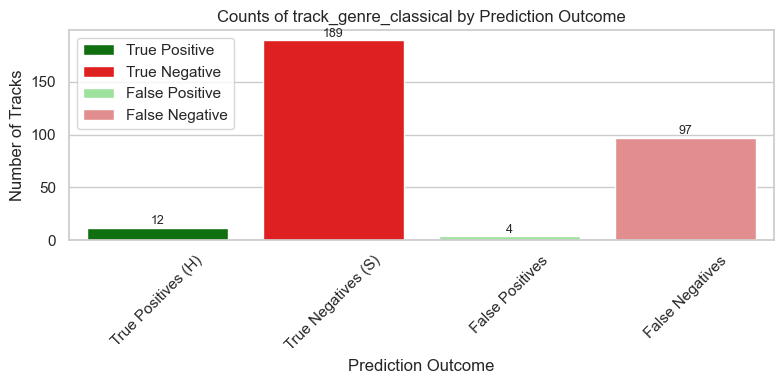

True Positives (H)     12
True Negatives (S)    189
False Positives         4
False Negatives        97
Name: track_genre_classical, dtype: int64


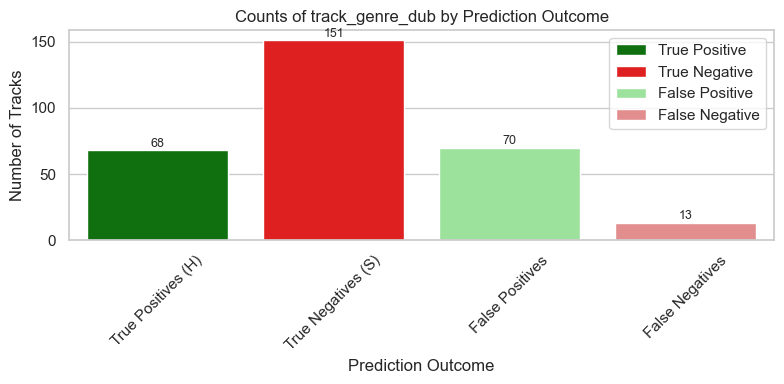

True Positives (H)     68
True Negatives (S)    151
False Positives        70
False Negatives        13
Name: track_genre_dub, dtype: int64


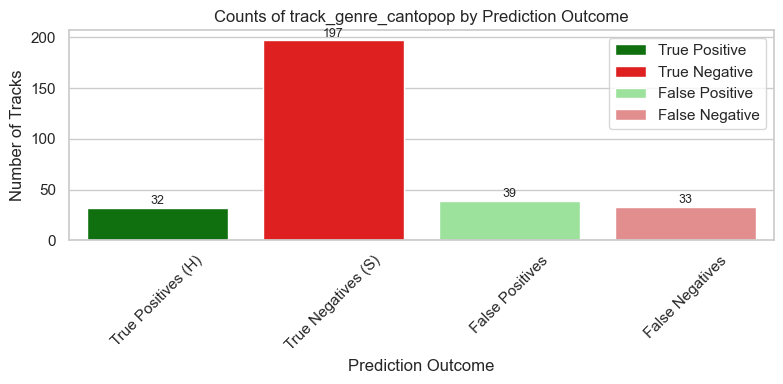

True Positives (H)     32
True Negatives (S)    197
False Positives        39
False Negatives        33
Name: track_genre_cantopop, dtype: int64


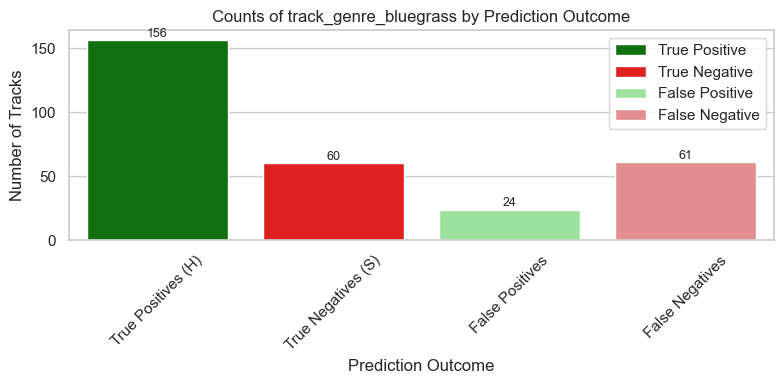

True Positives (H)    156
True Negatives (S)     60
False Positives        24
False Negatives        61
Name: track_genre_bluegrass, dtype: int64


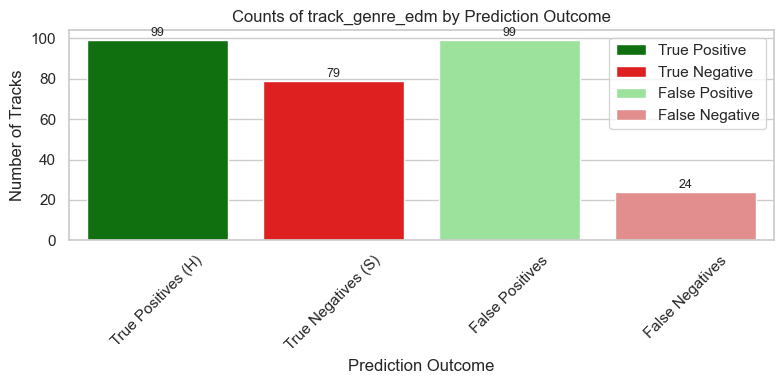

True Positives (H)    99
True Negatives (S)    79
False Positives       99
False Negatives       24
Name: track_genre_edm, dtype: int64


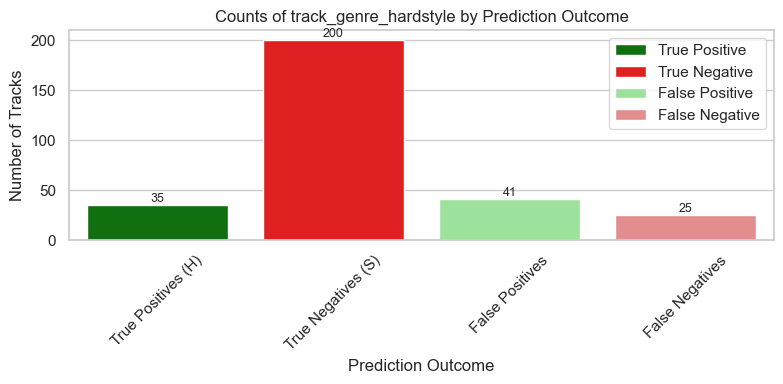

True Positives (H)     35
True Negatives (S)    200
False Positives        41
False Negatives        25
Name: track_genre_hardstyle, dtype: int64


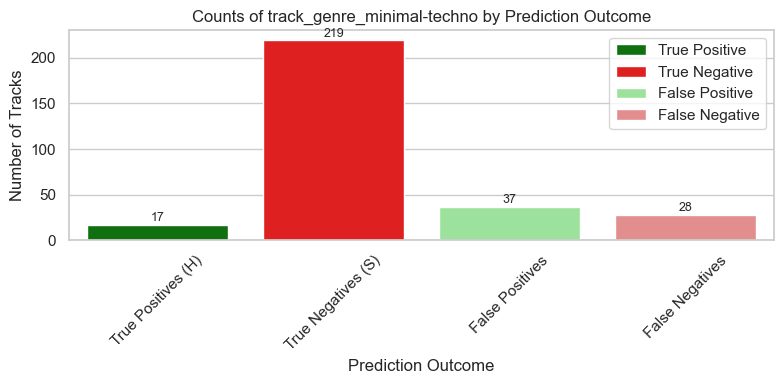

True Positives (H)     17
True Negatives (S)    219
False Positives        37
False Negatives        28
Name: track_genre_minimal-techno, dtype: int64


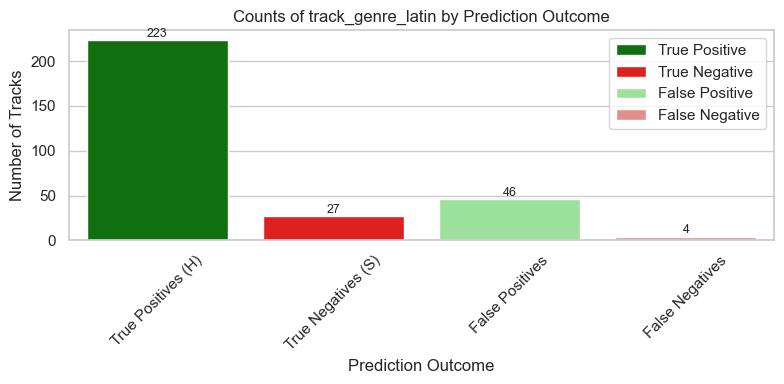

True Positives (H)    223
True Negatives (S)     27
False Positives        46
False Negatives         4
Name: track_genre_latin, dtype: int64


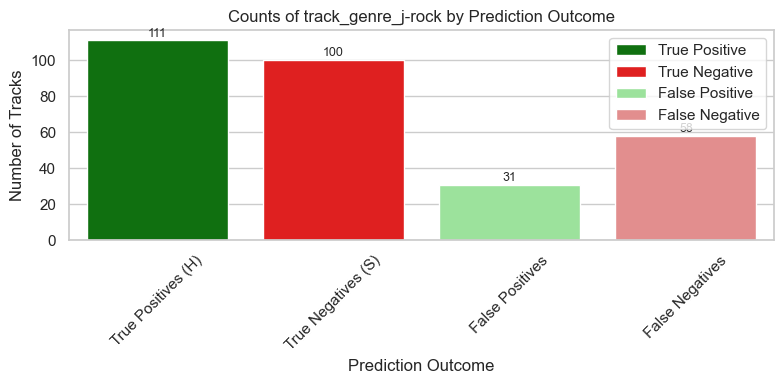

True Positives (H)    111
True Negatives (S)    100
False Positives        31
False Negatives        58
Name: track_genre_j-rock, dtype: int64


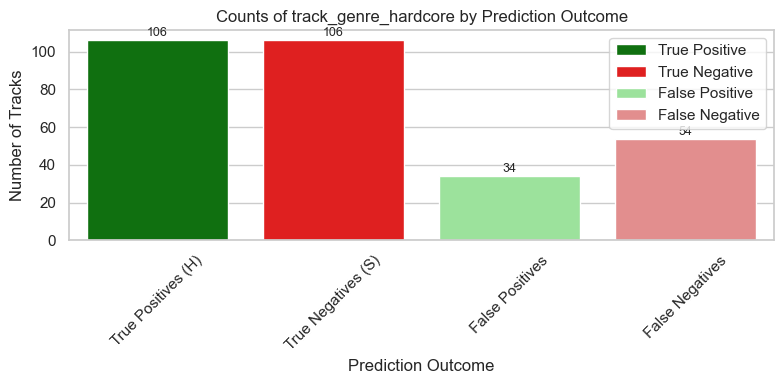

True Positives (H)    106
True Negatives (S)    106
False Positives        34
False Negatives        54
Name: track_genre_hardcore, dtype: int64


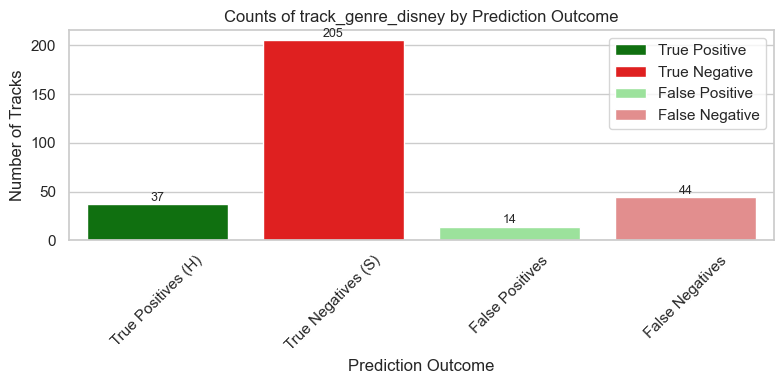

True Positives (H)     37
True Negatives (S)    205
False Positives        14
False Negatives        44
Name: track_genre_disney, dtype: int64


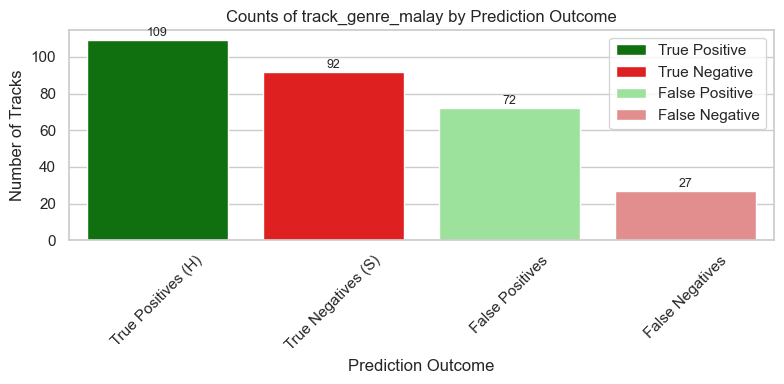

True Positives (H)    109
True Negatives (S)     92
False Positives        72
False Negatives        27
Name: track_genre_malay, dtype: int64


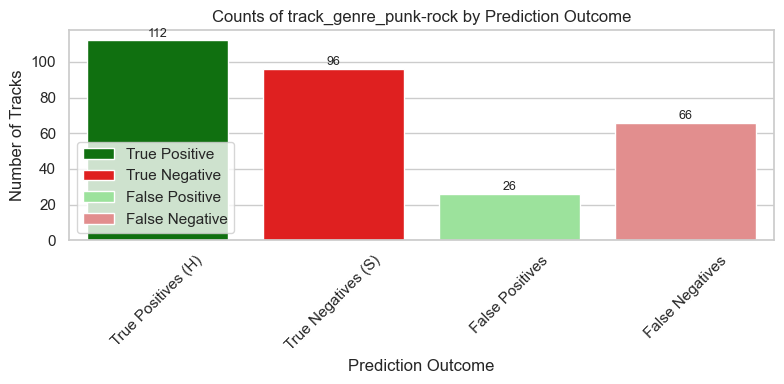

True Positives (H)    112
True Negatives (S)     96
False Positives        26
False Negatives        66
Name: track_genre_punk-rock, dtype: int64


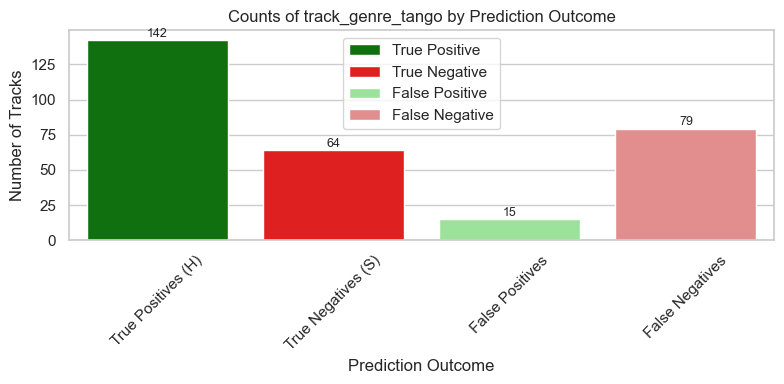

True Positives (H)    142
True Negatives (S)     64
False Positives        15
False Negatives        79
Name: track_genre_tango, dtype: int64


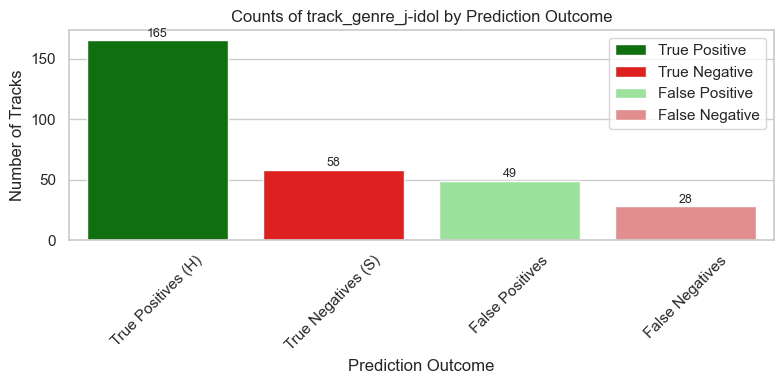

True Positives (H)    165
True Negatives (S)     58
False Positives        49
False Negatives        28
Name: track_genre_j-idol, dtype: int64


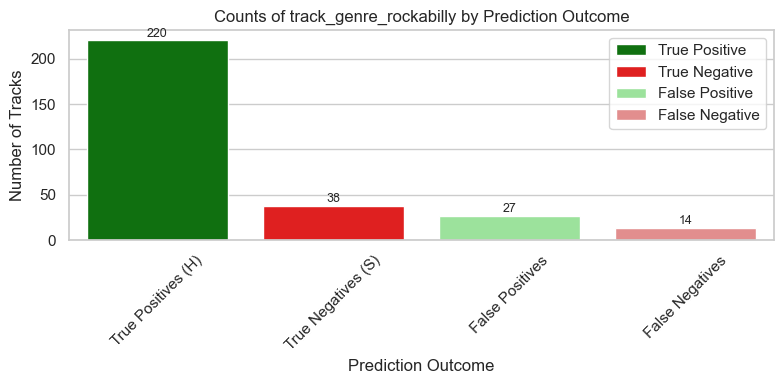

True Positives (H)    220
True Negatives (S)     38
False Positives        27
False Negatives        14
Name: track_genre_rockabilly, dtype: int64


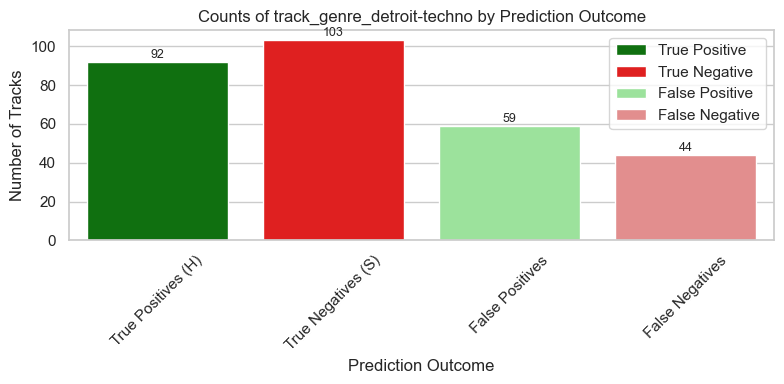

True Positives (H)     92
True Negatives (S)    103
False Positives        59
False Negatives        44
Name: track_genre_detroit-techno, dtype: int64


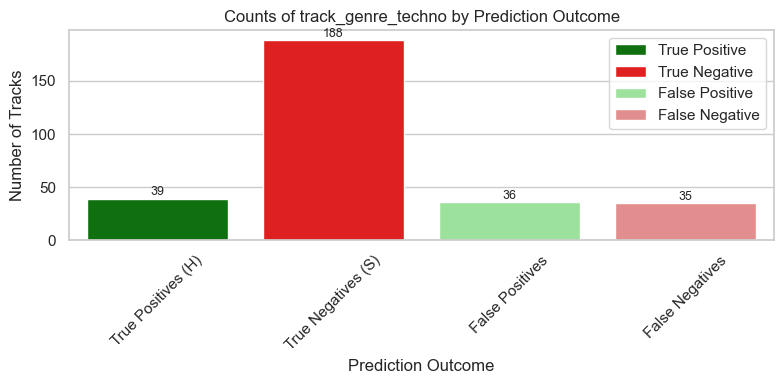

True Positives (H)     39
True Negatives (S)    188
False Positives        36
False Negatives        35
Name: track_genre_techno, dtype: int64


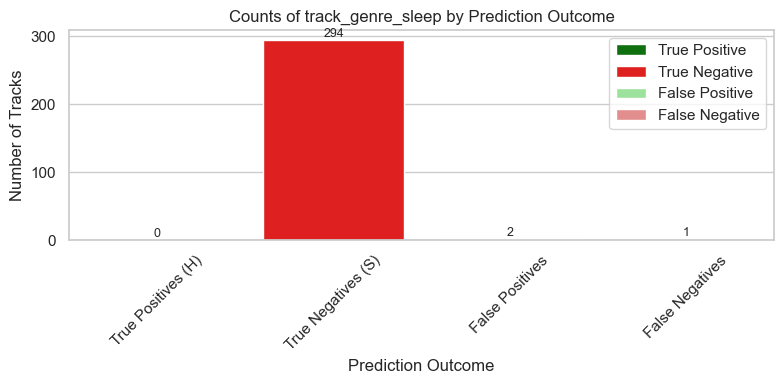

True Positives (H)      0
True Negatives (S)    294
False Positives         2
False Negatives         1
Name: track_genre_sleep, dtype: int64


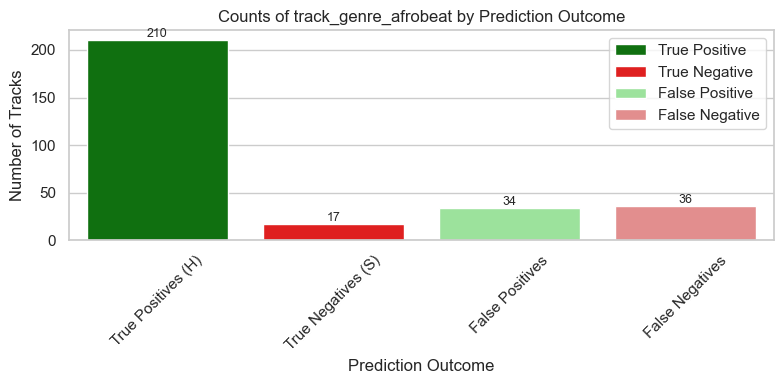

True Positives (H)    210
True Negatives (S)     17
False Positives        34
False Negatives        36
Name: track_genre_afrobeat, dtype: int64


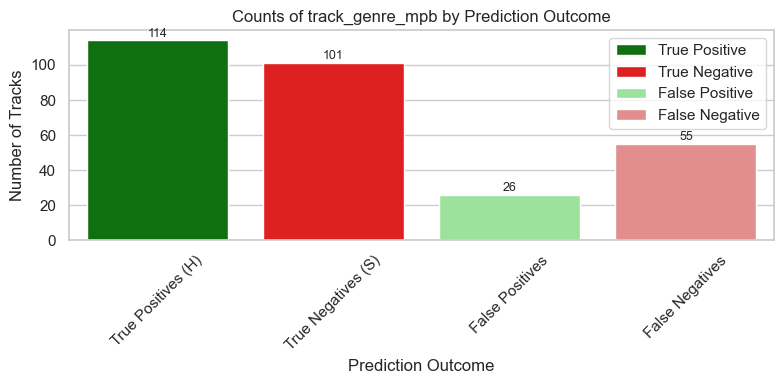

True Positives (H)    114
True Negatives (S)    101
False Positives        26
False Negatives        55
Name: track_genre_mpb, dtype: int64


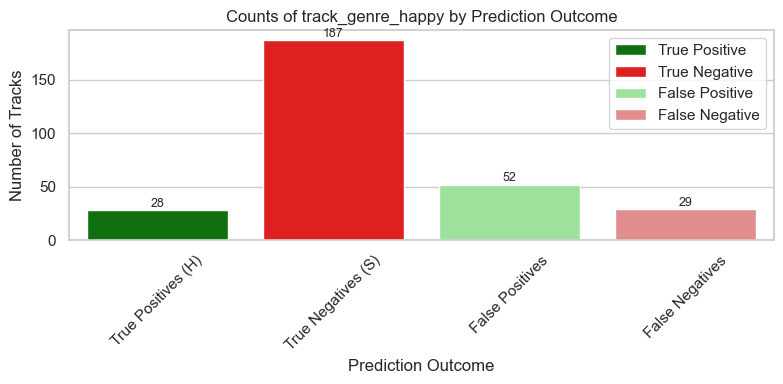

True Positives (H)     28
True Negatives (S)    187
False Positives        52
False Negatives        29
Name: track_genre_happy, dtype: int64


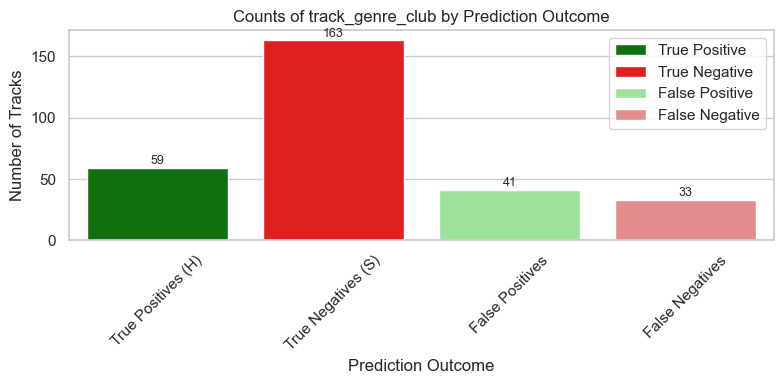

True Positives (H)     59
True Negatives (S)    163
False Positives        41
False Negatives        33
Name: track_genre_club, dtype: int64


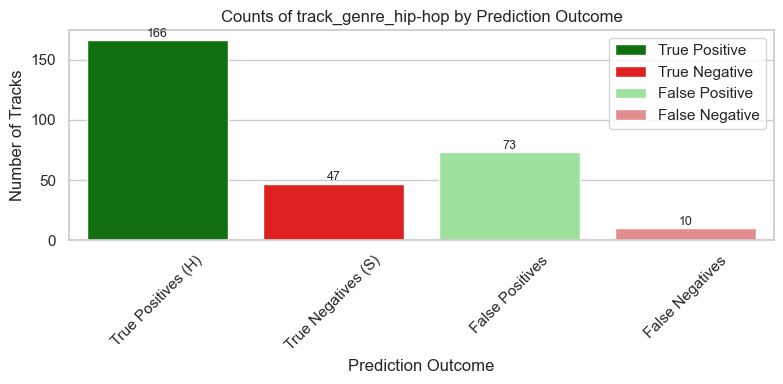

True Positives (H)    166
True Negatives (S)     47
False Positives        73
False Negatives        10
Name: track_genre_hip-hop, dtype: int64


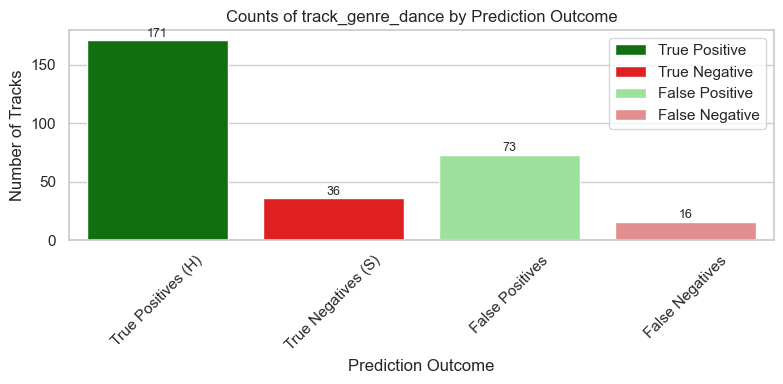

True Positives (H)    171
True Negatives (S)     36
False Positives        73
False Negatives        16
Name: track_genre_dance, dtype: int64


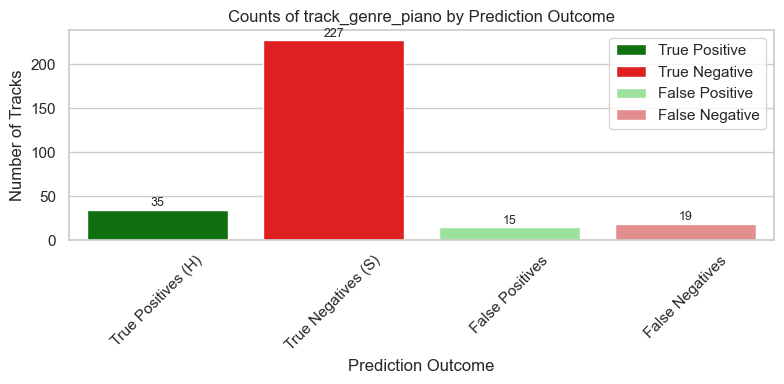

True Positives (H)     35
True Negatives (S)    227
False Positives        15
False Negatives        19
Name: track_genre_piano, dtype: int64


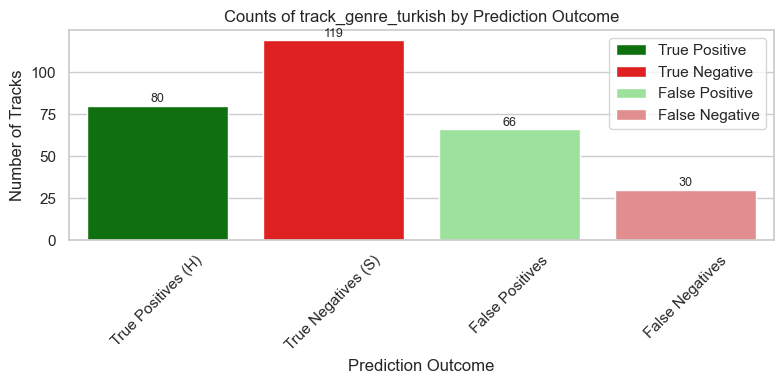

True Positives (H)     80
True Negatives (S)    119
False Positives        66
False Negatives        30
Name: track_genre_turkish, dtype: int64


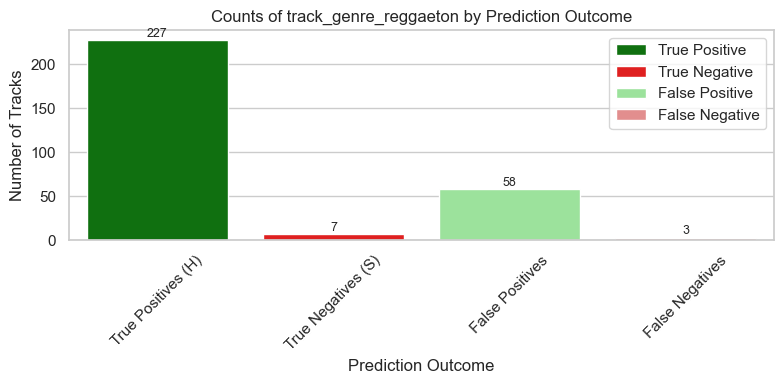

True Positives (H)    227
True Negatives (S)      7
False Positives        58
False Negatives         3
Name: track_genre_reggaeton, dtype: int64


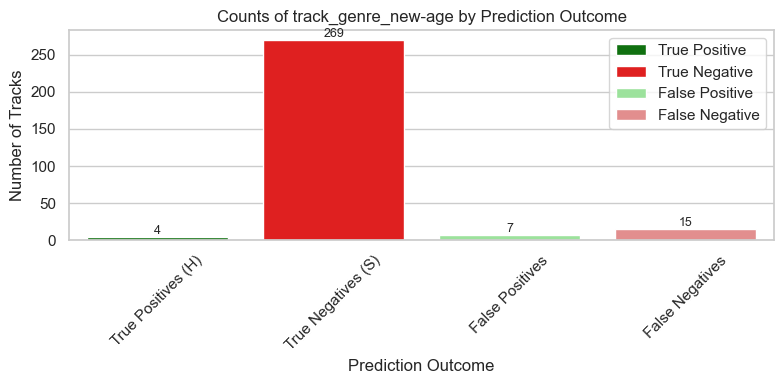

True Positives (H)      4
True Negatives (S)    269
False Positives         7
False Negatives        15
Name: track_genre_new-age, dtype: int64


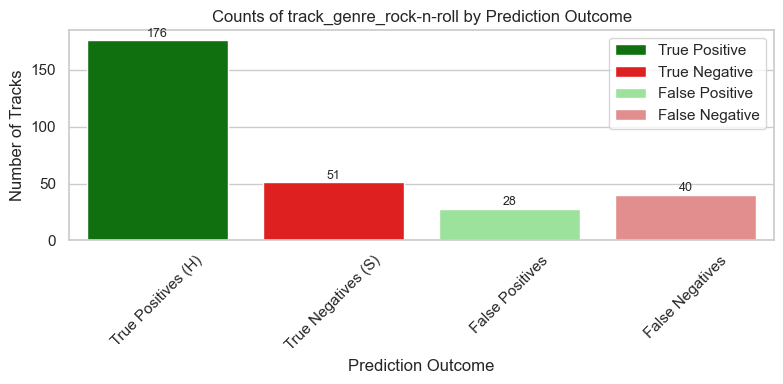

True Positives (H)    176
True Negatives (S)     51
False Positives        28
False Negatives        40
Name: track_genre_rock-n-roll, dtype: int64


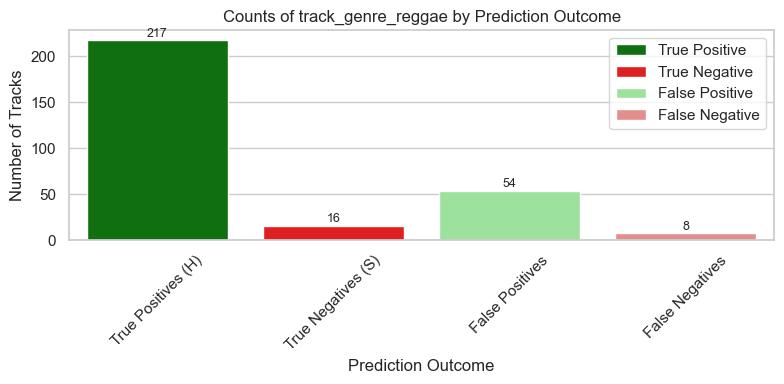

True Positives (H)    217
True Negatives (S)     16
False Positives        54
False Negatives         8
Name: track_genre_reggae, dtype: int64


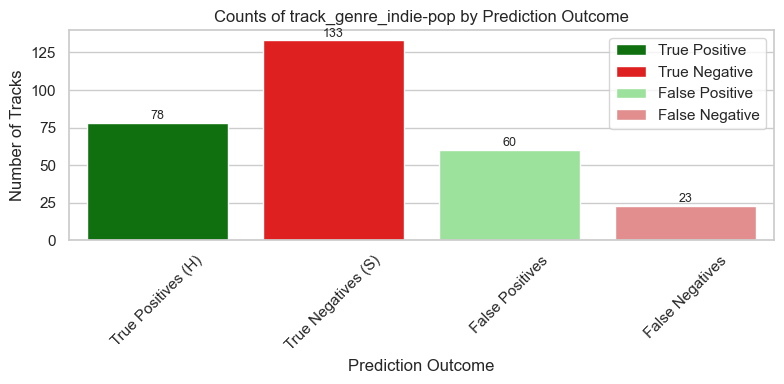

True Positives (H)     78
True Negatives (S)    133
False Positives        60
False Negatives        23
Name: track_genre_indie-pop, dtype: int64


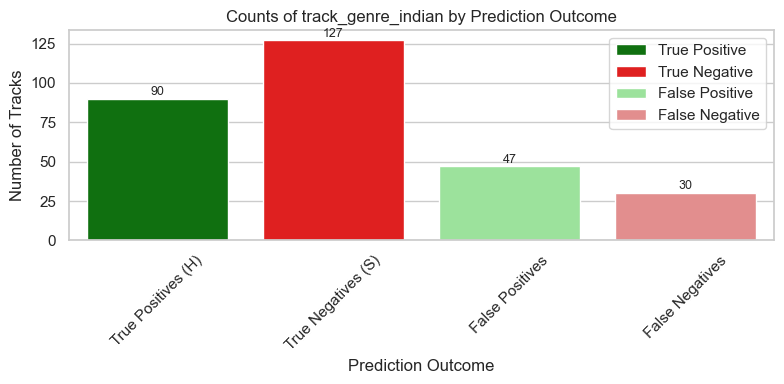

True Positives (H)     90
True Negatives (S)    127
False Positives        47
False Negatives        30
Name: track_genre_indian, dtype: int64


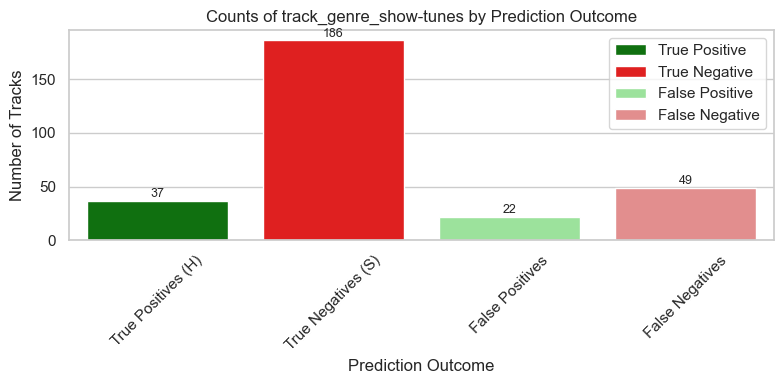

True Positives (H)     37
True Negatives (S)    186
False Positives        22
False Negatives        49
Name: track_genre_show-tunes, dtype: int64


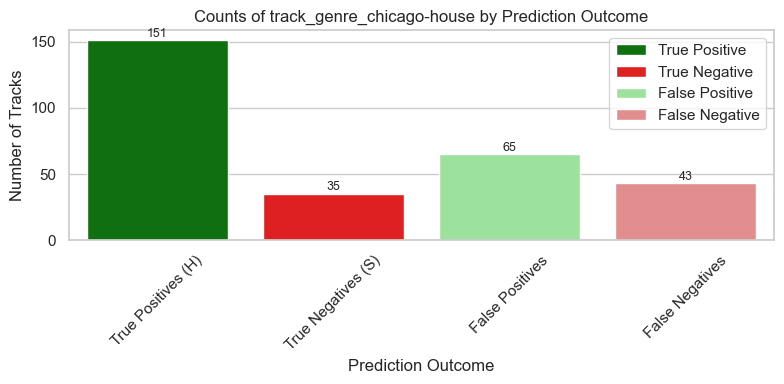

True Positives (H)    151
True Negatives (S)     35
False Positives        65
False Negatives        43
Name: track_genre_chicago-house, dtype: int64


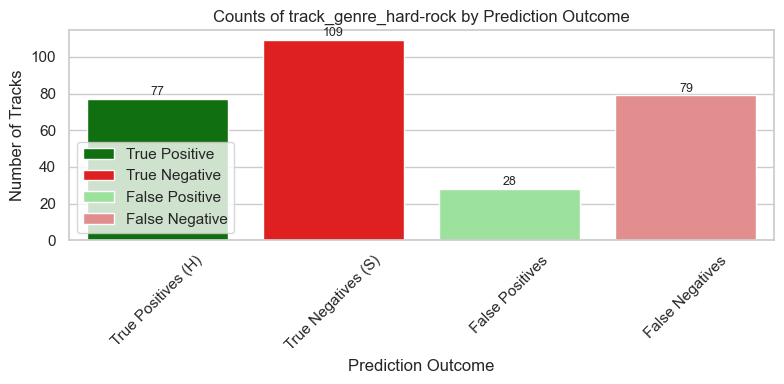

True Positives (H)     77
True Negatives (S)    109
False Positives        28
False Negatives        79
Name: track_genre_hard-rock, dtype: int64


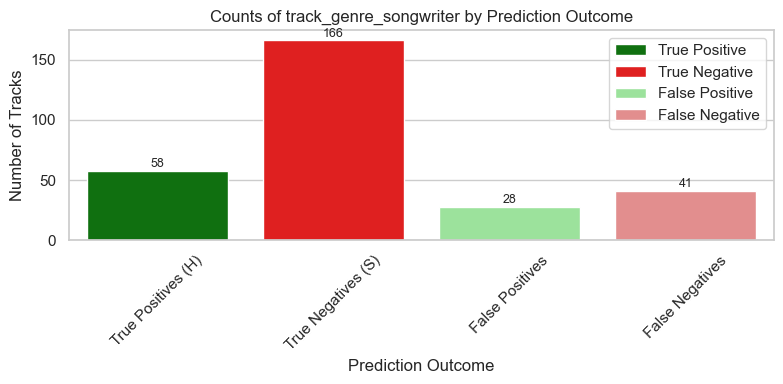

True Positives (H)     58
True Negatives (S)    166
False Positives        28
False Negatives        41
Name: track_genre_songwriter, dtype: int64


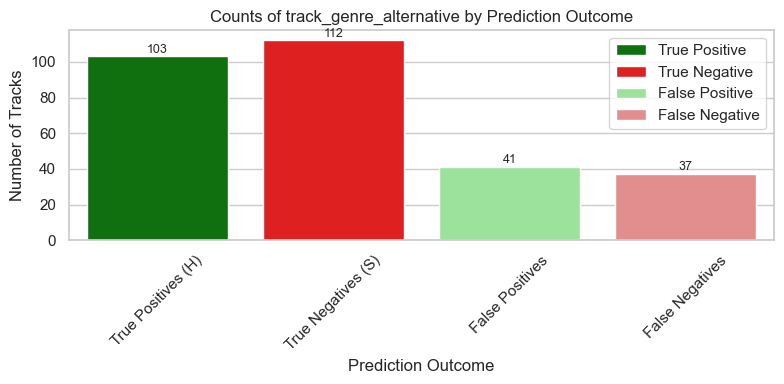

True Positives (H)    103
True Negatives (S)    112
False Positives        41
False Negatives        37
Name: track_genre_alternative, dtype: int64


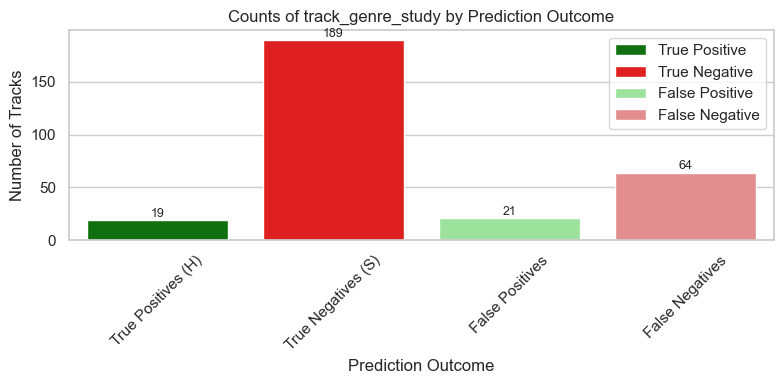

True Positives (H)     19
True Negatives (S)    189
False Positives        21
False Negatives        64
Name: track_genre_study, dtype: int64


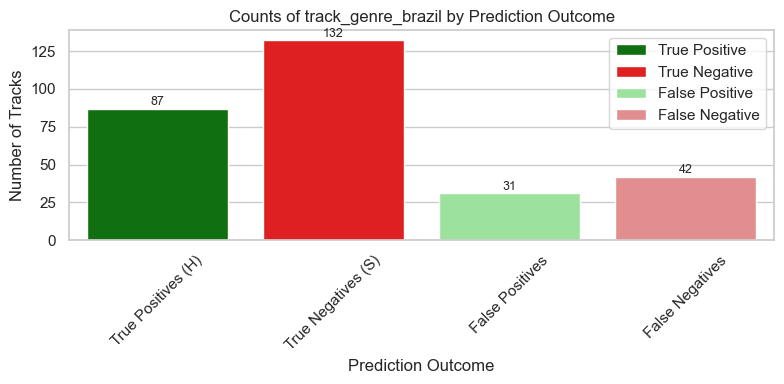

True Positives (H)     87
True Negatives (S)    132
False Positives        31
False Negatives        42
Name: track_genre_brazil, dtype: int64


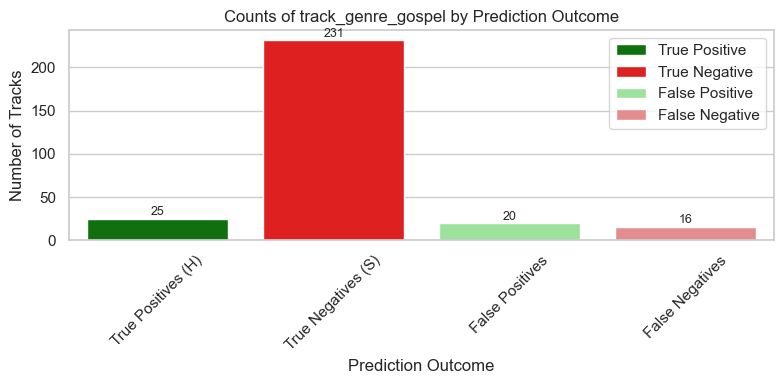

True Positives (H)     25
True Negatives (S)    231
False Positives        20
False Negatives        16
Name: track_genre_gospel, dtype: int64


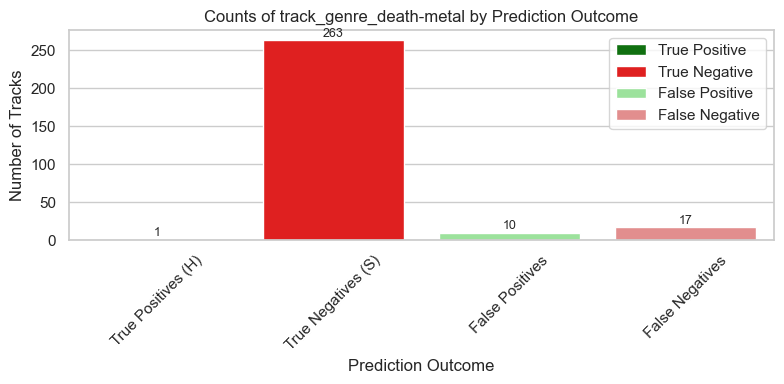

True Positives (H)      1
True Negatives (S)    263
False Positives        10
False Negatives        17
Name: track_genre_death-metal, dtype: int64


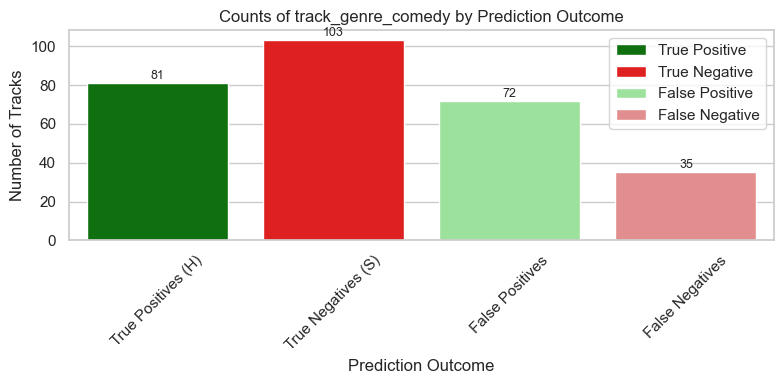

True Positives (H)     81
True Negatives (S)    103
False Positives        72
False Negatives        35
Name: track_genre_comedy, dtype: int64


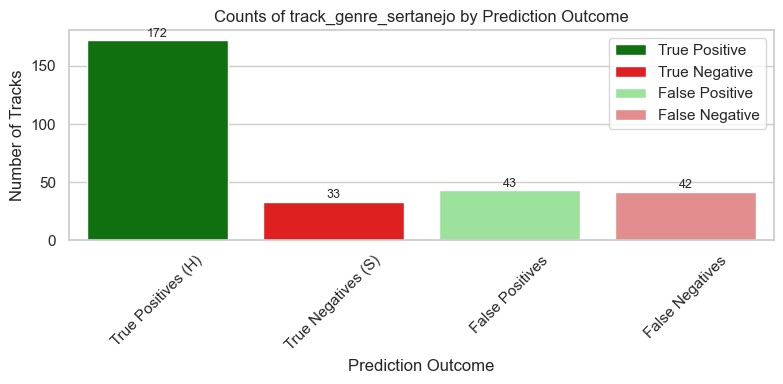

True Positives (H)    172
True Negatives (S)     33
False Positives        43
False Negatives        42
Name: track_genre_sertanejo, dtype: int64


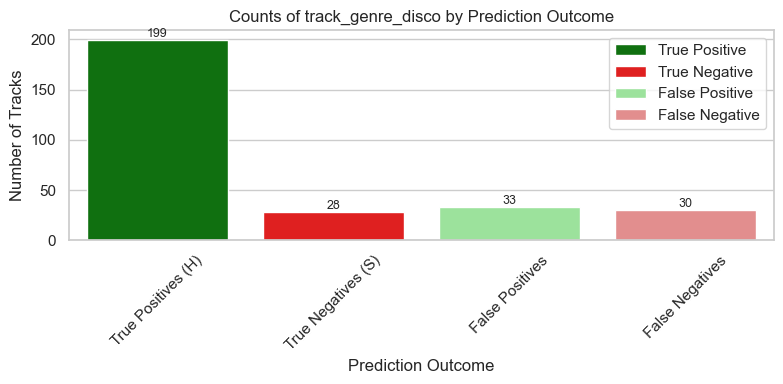

True Positives (H)    199
True Negatives (S)     28
False Positives        33
False Negatives        30
Name: track_genre_disco, dtype: int64


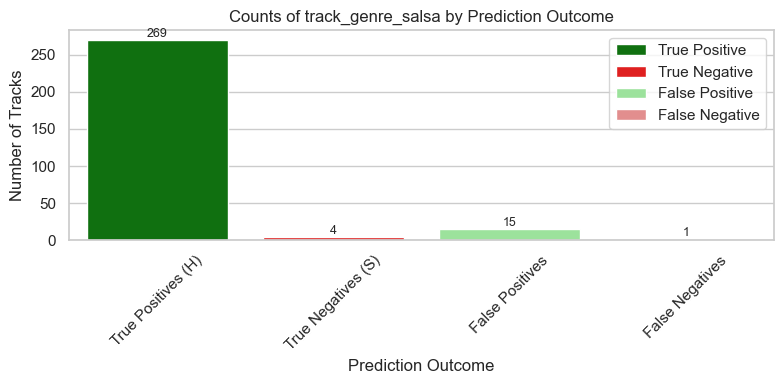

True Positives (H)    269
True Negatives (S)      4
False Positives        15
False Negatives         1
Name: track_genre_salsa, dtype: int64


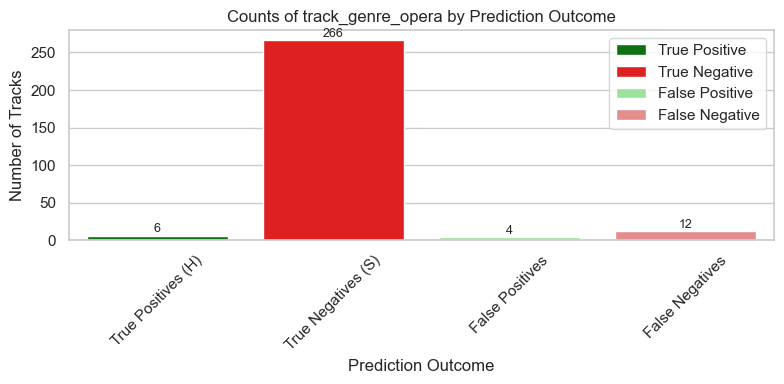

True Positives (H)      6
True Negatives (S)    266
False Positives         4
False Negatives        12
Name: track_genre_opera, dtype: int64


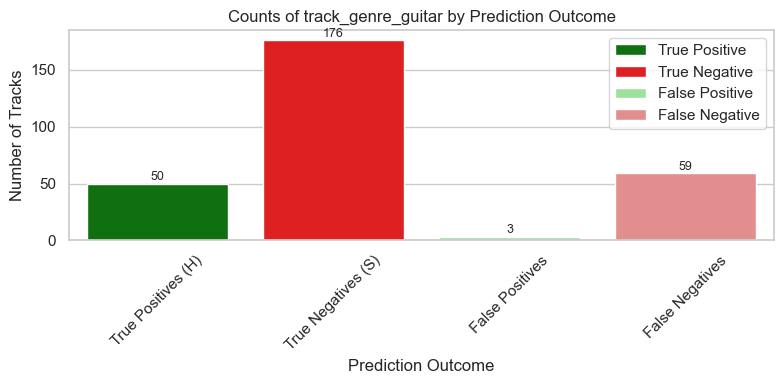

True Positives (H)     50
True Negatives (S)    176
False Positives         3
False Negatives        59
Name: track_genre_guitar, dtype: int64


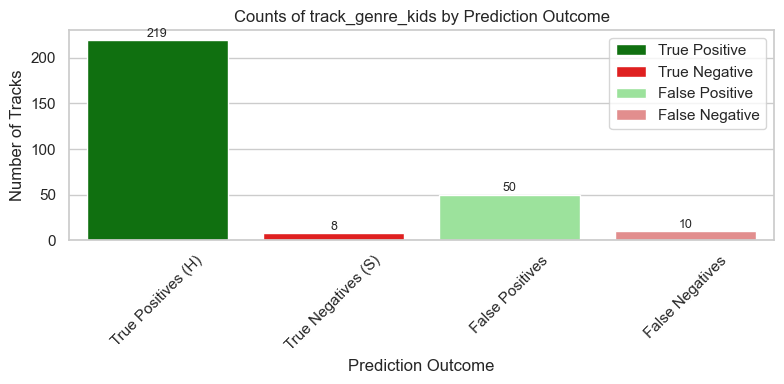

True Positives (H)    219
True Negatives (S)      8
False Positives        50
False Negatives        10
Name: track_genre_kids, dtype: int64


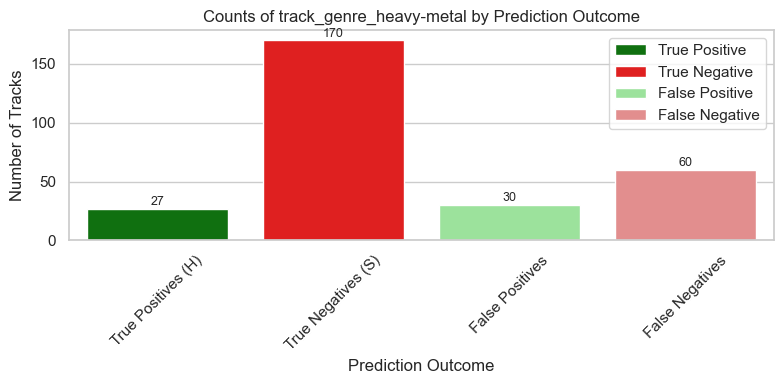

True Positives (H)     27
True Negatives (S)    170
False Positives        30
False Negatives        60
Name: track_genre_heavy-metal, dtype: int64


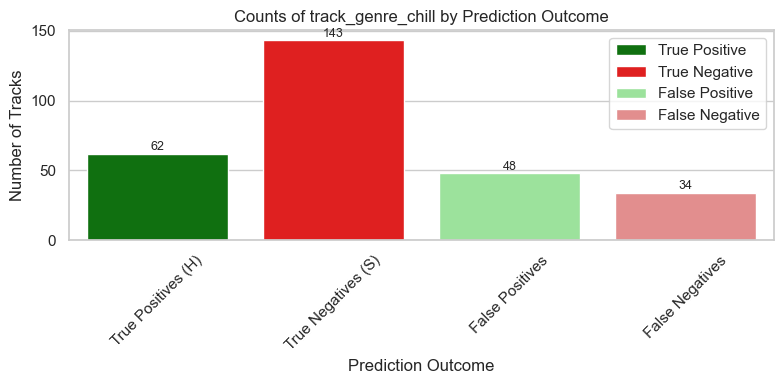

True Positives (H)     62
True Negatives (S)    143
False Positives        48
False Negatives        34
Name: track_genre_chill, dtype: int64


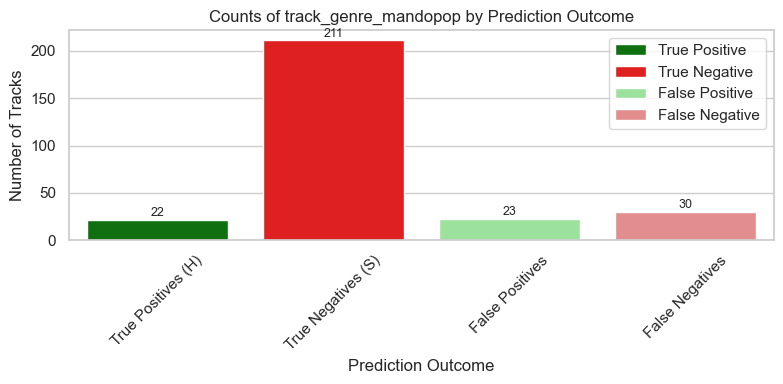

True Positives (H)     22
True Negatives (S)    211
False Positives        23
False Negatives        30
Name: track_genre_mandopop, dtype: int64


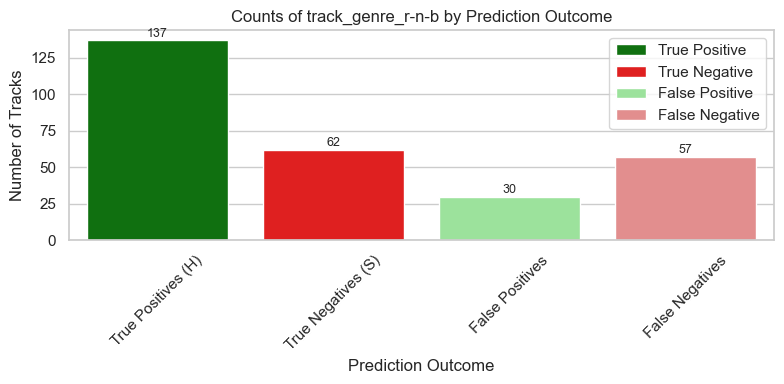

True Positives (H)    137
True Negatives (S)     62
False Positives        30
False Negatives        57
Name: track_genre_r-n-b, dtype: int64


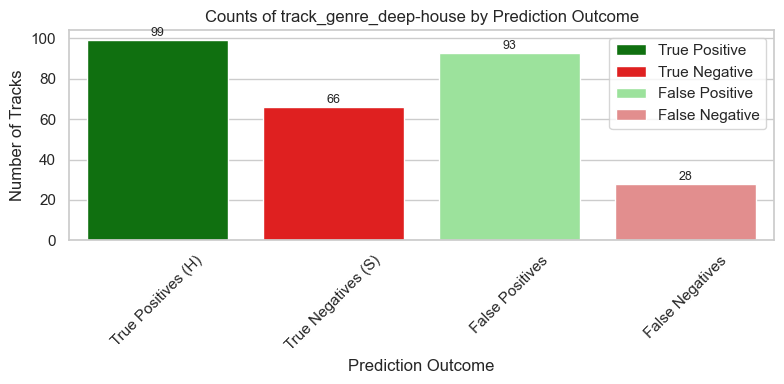

True Positives (H)    99
True Negatives (S)    66
False Positives       93
False Negatives       28
Name: track_genre_deep-house, dtype: int64


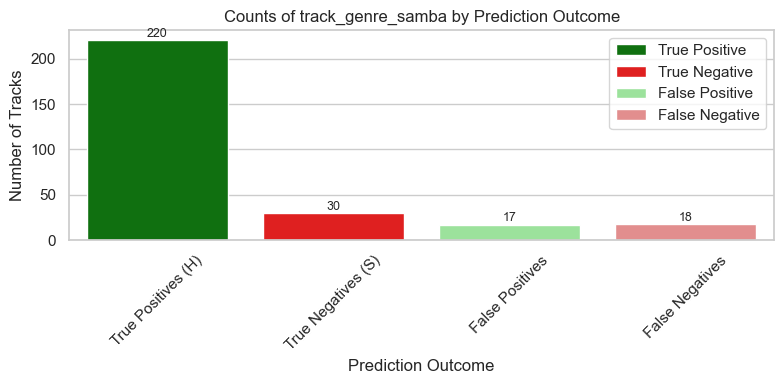

True Positives (H)    220
True Negatives (S)     30
False Positives        17
False Negatives        18
Name: track_genre_samba, dtype: int64


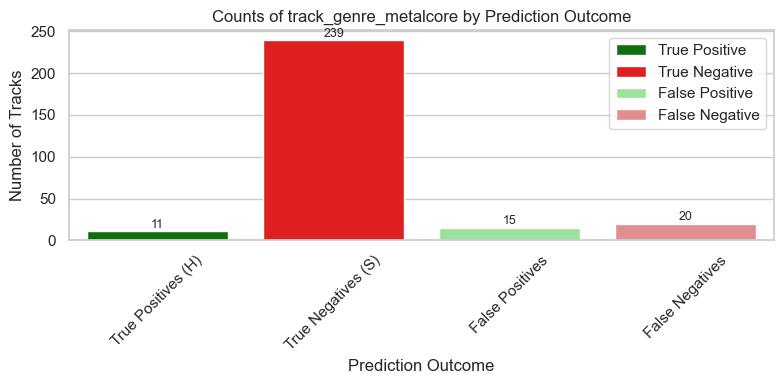

True Positives (H)     11
True Negatives (S)    239
False Positives        15
False Negatives        20
Name: track_genre_metalcore, dtype: int64


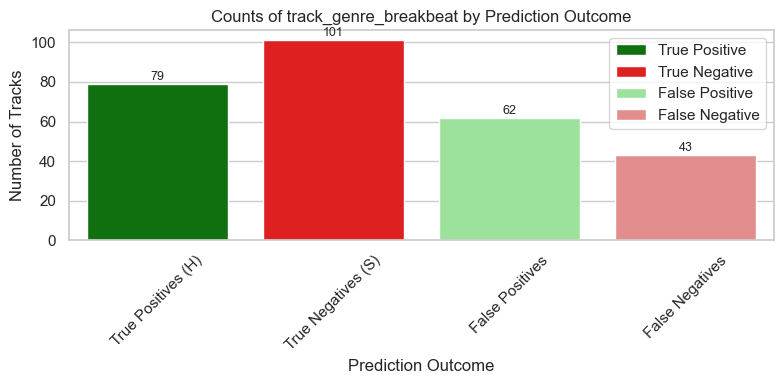

True Positives (H)     79
True Negatives (S)    101
False Positives        62
False Negatives        43
Name: track_genre_breakbeat, dtype: int64


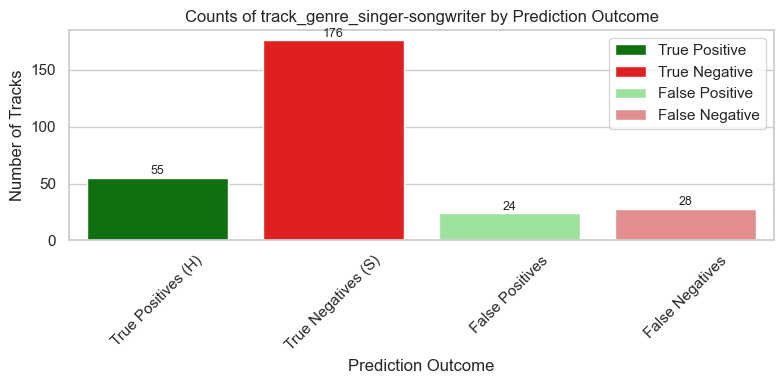

True Positives (H)     55
True Negatives (S)    176
False Positives        24
False Negatives        28
Name: track_genre_singer-songwriter, dtype: int64


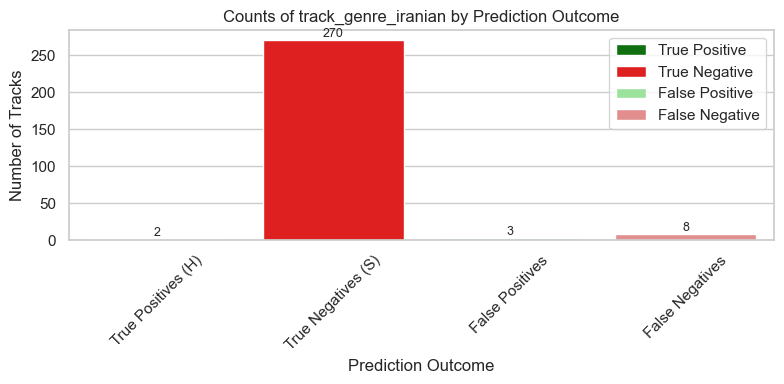

True Positives (H)      2
True Negatives (S)    270
False Positives         3
False Negatives         8
Name: track_genre_iranian, dtype: int64


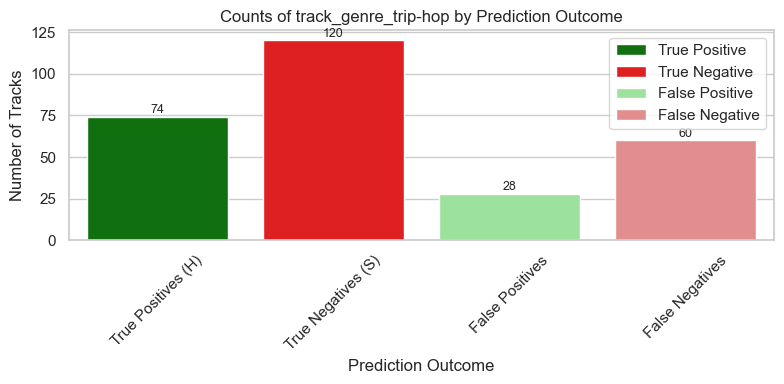

True Positives (H)     74
True Negatives (S)    120
False Positives        28
False Negatives        60
Name: track_genre_trip-hop, dtype: int64


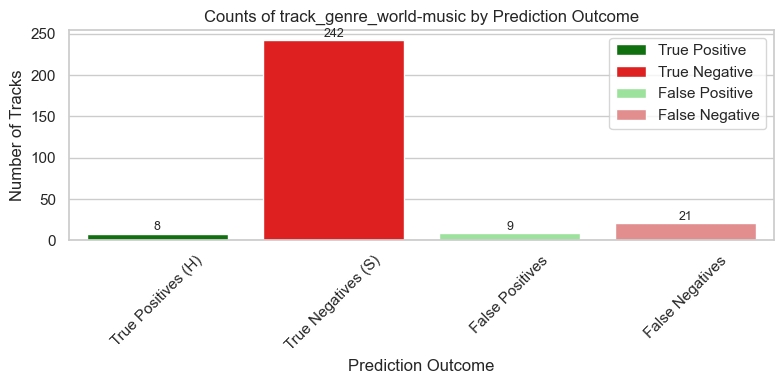

True Positives (H)      8
True Negatives (S)    242
False Positives         9
False Negatives        21
Name: track_genre_world-music, dtype: int64


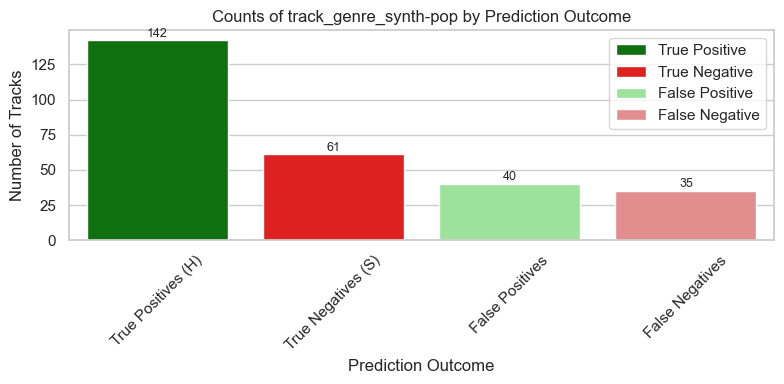

True Positives (H)    142
True Negatives (S)     61
False Positives        40
False Negatives        35
Name: track_genre_synth-pop, dtype: int64


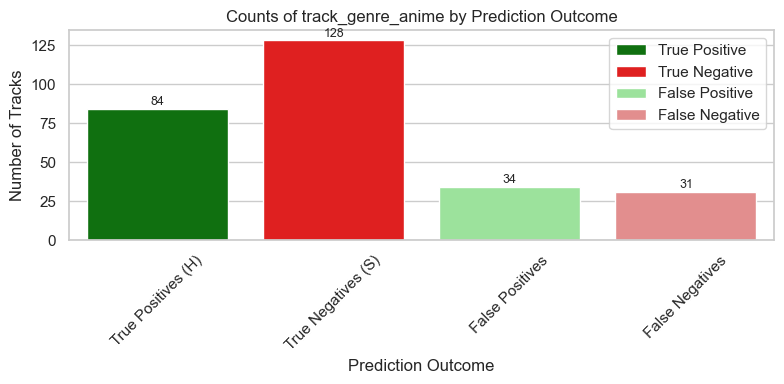

True Positives (H)     84
True Negatives (S)    128
False Positives        34
False Negatives        31
Name: track_genre_anime, dtype: int64


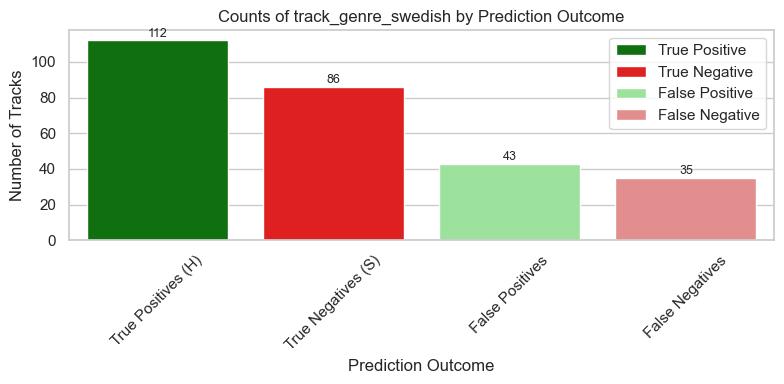

True Positives (H)    112
True Negatives (S)     86
False Positives        43
False Negatives        35
Name: track_genre_swedish, dtype: int64


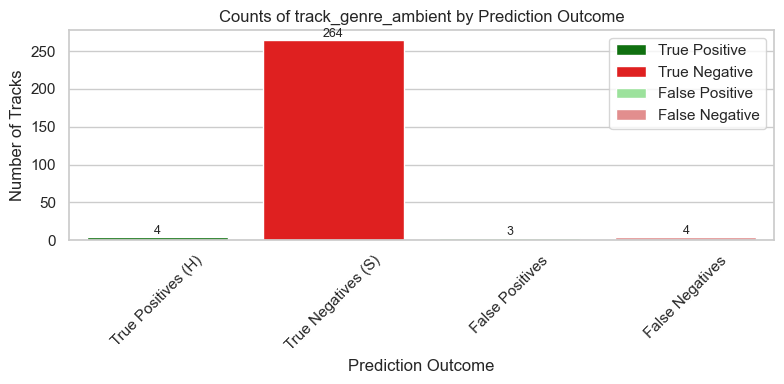

True Positives (H)      4
True Negatives (S)    264
False Positives         3
False Negatives         4
Name: track_genre_ambient, dtype: int64


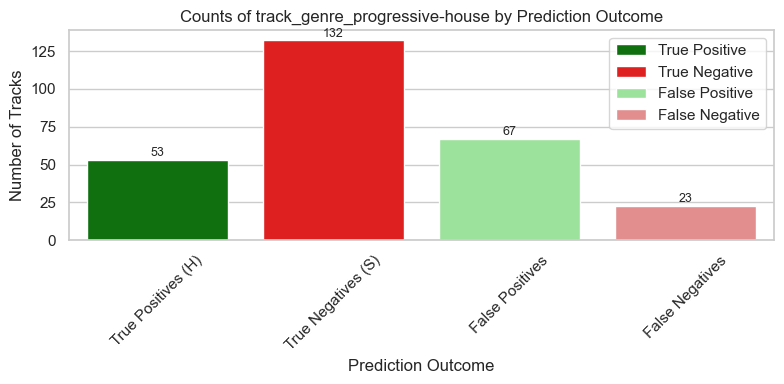

True Positives (H)     53
True Negatives (S)    132
False Positives        67
False Negatives        23
Name: track_genre_progressive-house, dtype: int64


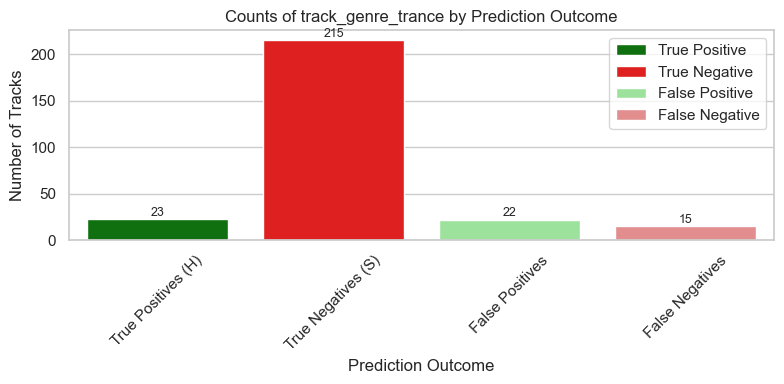

True Positives (H)     23
True Negatives (S)    215
False Positives        22
False Negatives        15
Name: track_genre_trance, dtype: int64


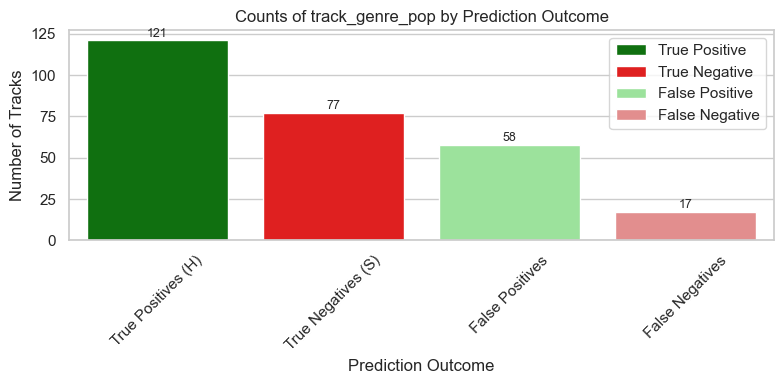

True Positives (H)    121
True Negatives (S)     77
False Positives        58
False Negatives        17
Name: track_genre_pop, dtype: int64


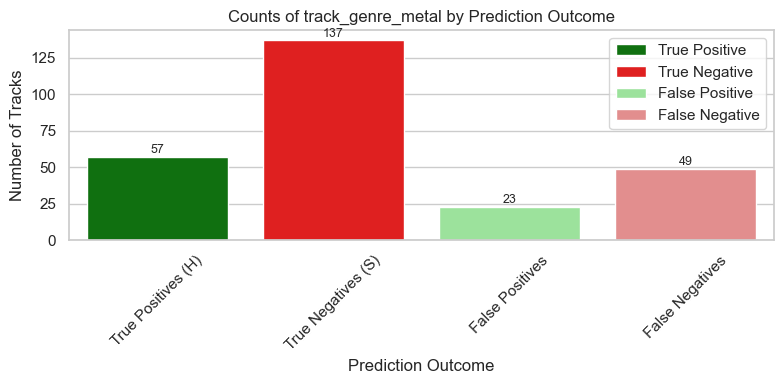

True Positives (H)     57
True Negatives (S)    137
False Positives        23
False Negatives        49
Name: track_genre_metal, dtype: int64


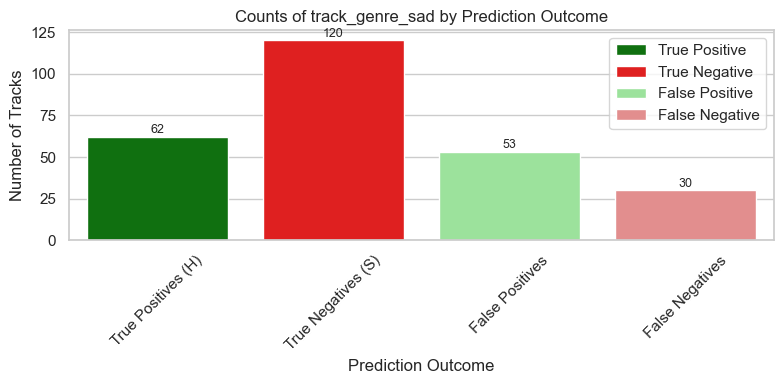

True Positives (H)     62
True Negatives (S)    120
False Positives        53
False Negatives        30
Name: track_genre_sad, dtype: int64


In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: prettier style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# --- Genre Counts per Prediction Outcome ---

# Ensure genre columns are all 0 or 1
genre_cols = [col for col in df.columns if col.startswith("track_genre")]


# Define the prediction outcome groups
groups = {
    "True Positives (H)": true_positives,
    "True Negatives (S)": true_negatives,
    "False Positives": false_positives,
    "False Negatives": false_negatives,
}


# Count genres per group
genre_counts = {
    group_name: (group_df[genre_cols]).astype(int).sum()
    for group_name, group_df in groups.items()
}


# Create a DataFrame
genre_counts_df = pd.DataFrame(genre_counts).T  # Outcomes as rows
# genre_counts_df.to_csv('output.csv', index=False)


top_genres = genre_counts_df.sum(axis=0).sort_values(ascending=False).index
# top_genres = genre_counts_df.sum(axis=0).sort_values(ascending=False).head(20).index


# Plot barplot for each genre
for genre in top_genres:
    plt.figure(figsize=(8, 4))
    ax = sns.barplot(
        x=genre_counts_df.index,
        y=genre_counts_df[genre].values,
        hue=["True Positive", "True Negative", "False Positive", "False Negative"],
        palette=["green", "red", "lightgreen", "lightcoral"],
    )

    # Add value labels above bars
    for i, value in enumerate(genre_counts_df[genre].values):
        ax.text(i, value + 0.5, str(int(value)), ha="center", va="bottom", fontsize=9)

    plt.title(f"Counts of {genre} by Prediction Outcome")
    plt.ylabel("Number of Tracks")
    plt.xlabel("Prediction Outcome")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(genre_counts_df[genre])